In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

# Load the dataset
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
imgs = df.to_numpy()

# Reshape the images from 784 (28x28) to (28,28)
X = imgs[:, 1:].reshape(-1, 28, 28)
print("Original shape:", X.shape)

# Convert images from NumPy array to PyTorch tensor and normalize them (0-255 -> 0-1)
X = torch.tensor(X, dtype=torch.float32) / 255.0

# Reshape X to include a channel dimension (required by the interpolation function)
X = X.unsqueeze(1)  # Shape becomes [batch_size, 1, 28, 28]
print("Reshaped for PyTorch (with channel):", X.shape)

# Downscale the images to 16x16 using PyTorch's interpolate function
X = F.interpolate(X, size=(16, 16), mode='bilinear', align_corners=False)

# Remove the extra channel dimension after resizing
X = X.squeeze(1)  # Shape becomes [batch_size, 14, 14]

# Extract labels
Y = imgs[:, 0]

# Replace Y with Y % 2 (binary classification: even vs odd)
#Y = torch.tensor(Y % 2, dtype=torch.int64)
Y = torch.tensor(Y, dtype=torch.int64)
print("Binary Labels shape:", Y.shape)


Original shape: (42000, 28, 28)
Reshaped for PyTorch (with channel): torch.Size([42000, 1, 28, 28])
Binary Labels shape: torch.Size([42000])


In [2]:
#import matplotlib.pyplot as plt
#plt.imshow(X[7])

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [5]:

X = X.reshape(-1, 1, 16, 16)

# Split the dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, shuffle=True)

# Convert Numpy arrays to PyTorch tensors
X_train_tensor = X_train
Y_train_tensor = Y_train
X_test_tensor = X_test
Y_test_tensor = Y_test

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_full = DataLoader(train_dataset, batch_size=len(X_train), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
len(X_train)

33600

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding='same')
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer (adjusted according to output shape from conv layers)
        
        self.fc1 = nn.Linear(32*4*4, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(x.size(0), -1)  # Flattening the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNN(num_classes=10)

# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the total number of trainable parameters
print(f"Total number of parameters: {count_parameters(model)}")


Total number of parameters: 38282


In [8]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch}: Loss: {running_loss / len(train_loader)}')

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Compute loss
            test_loss += criterion(output, target).item()
            
            # Get the predicted class
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

In [9]:
import torch
import random
from collections import defaultdict
def addPixel(images, batch):
    # Get the dimensions of the batch (B is the batch size, C is the number of channels, H and W are the height and width of the images)
    
    B, C, H, W = batch.shape

    # Generate random indices for height and width
    rand_h = torch.randint(0, H, (B, 1, 1))
    rand_w = torch.randint(0, W, (B, 1, 1))

    # Using broadcasting to select pixels from the batch at random indices for each image
    # Take random height (h) and width (w) coordinates for each image in the batch
    batch[torch.arange(B), :, rand_h.squeeze(), rand_w.squeeze()] = images[torch.arange(B), :, rand_h.squeeze(), rand_w.squeeze()]

    return batch


def random_pixel_mask_batch(images, num_pixels):
    batch = torch.ones(images.shape[0], 1, 16, 16) * (-1)
    
    # Create a dictionary to store image indices for each pixel count
    pixel_groups = defaultdict(list)
    
    # Assign random pixel counts to images and group them
    for i in range(images.shape[0]):
        pixels_to_add = random.randint(0, num_pixels)
        pixel_groups[pixels_to_add].append(i)
    
    # Process each group of images with the same pixel count
    for pixel_count, indices in pixel_groups.items():
        if not indices:  # Skip if no images for this pixel count
            continue
            
        # Convert indices list to tensor
        indices = torch.tensor(indices)
        
        # Select the images and their corresponding batch locations
        selected_images = images[indices]
        selected_batch = batch[indices]
        
        # Add pixels for this group
        for _ in range(pixel_count):
            selected_batch = addPixel(selected_images, selected_batch)
        
        # Update the original batch with processed images
        batch[indices] = selected_batch
    
    return batch

In [10]:
def train(model, device, train_loader, optimizer, criterion, epoch, num_pixels=8):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Apply the random pixel mask transformation
        data = random_pixel_mask_batch(data.cpu(), num_pixels=num_pixels).to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Compute loss
        loss = criterion(output, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch}: Loss: {running_loss / len(train_loader)}')

def test(model, device, test_loader, criterion, num_pixels=8):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Apply the random pixel mask transformation
            data = random_pixel_mask_batch(data.cpu(), num_pixels=num_pixels).to(device)
            
            # Forward pass
            output = model(data)
            
            # Compute loss
            test_loss += criterion(output, target).item()
            
            # Get the predicted class
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Number of pixels to retain
num_pixels = 8

# Train and test the model with the modified input
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, num_pixels)
    test(model, device, test_loader, criterion, num_pixels)

Epoch 1: Loss: 2.301468422918609
Test Loss: 2.2988, Accuracy: 1011/8400 (12.04%)
Epoch 2: Loss: 2.2927760138656152
Test Loss: 2.2753, Accuracy: 1271/8400 (15.13%)
Epoch 3: Loss: 2.2581930991375083
Test Loss: 2.2390, Accuracy: 1295/8400 (15.42%)
Epoch 4: Loss: 2.226217356595126
Test Loss: 2.2170, Accuracy: 1394/8400 (16.60%)
Epoch 5: Loss: 2.208563967184587
Test Loss: 2.2049, Accuracy: 1431/8400 (17.04%)
Epoch 6: Loss: 2.1996527115503945
Test Loss: 2.1857, Accuracy: 1510/8400 (17.98%)
Epoch 7: Loss: 2.1863132931969385
Test Loss: 2.1791, Accuracy: 1504/8400 (17.90%)
Epoch 8: Loss: 2.1709926056139395
Test Loss: 2.1636, Accuracy: 1574/8400 (18.74%)
Epoch 9: Loss: 2.1622492689074893
Test Loss: 2.1606, Accuracy: 1559/8400 (18.56%)
Epoch 10: Loss: 2.1606780290603638
Test Loss: 2.1570, Accuracy: 1554/8400 (18.50%)
Epoch 11: Loss: 2.1512588985038525
Test Loss: 2.1552, Accuracy: 1610/8400 (19.17%)
Epoch 12: Loss: 2.142006693464337
Test Loss: 2.1382, Accuracy: 1640/8400 (19.52%)
Epoch 13: Loss: 2

In [13]:
probs=torch.softmax(model(random_pixel_mask_batch(X_test.cpu(), num_pixels=8).to(device)),axis=1).cpu()

odd_probs = probs[:, [1, 3, 5, 7, 9]].sum(dim=1)
even_probs = probs[:, [0, 2, 4, 6, 8]].sum(dim=1)
amount1=(torch.sum(((Y_test%2)==0)==(even_probs>0.5)))
print(amount1.item()/Y_test.shape[0])

0.5904761904761905


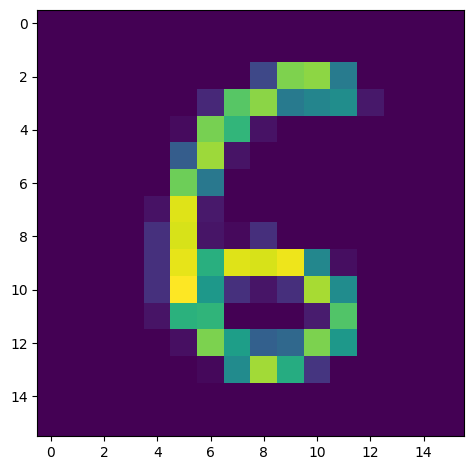

In [14]:
plt.imshow(X_test[5][0])
plt.tight_layout()
plt.savefig('number6.png', dpi=300)
plt.show()

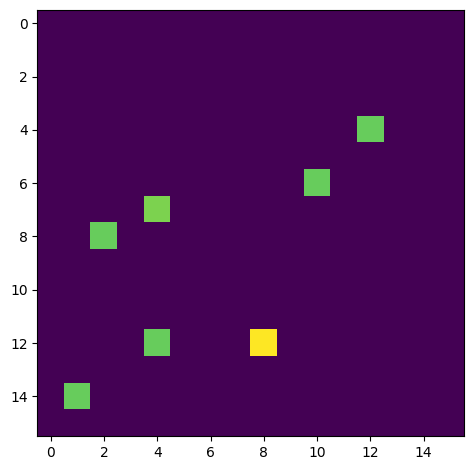

In [15]:
k=torch.ones_like(X_test)*-1
for i in range(8):
    k=addPixel(X_test,k)
plt.imshow(k[5][0])
plt.tight_layout()
plt.savefig('number6pixels8.png', dpi=300)
plt.show()

In [16]:
def confidence_score(results):
    return torch.max(torch.softmax(results,dim=1),axis=1)[0]

In [17]:
class parallelGame:
    tensor=None
    def __init__(self,game_tensor):
        self.tensor=game_tensor
    def evaluate(self,model,metric):
        with torch.no_grad():
            return metric(model(self.tensor.to(device)).cpu())
    

(array([1.749e+03, 6.110e+02, 6.230e+02, 6.500e+02, 6.850e+02, 6.220e+02,
        5.700e+02, 5.460e+02, 3.620e+02, 2.900e+02, 2.450e+02, 2.210e+02,
        1.820e+02, 1.680e+02, 1.280e+02, 9.700e+01, 8.200e+01, 7.000e+01,
        6.600e+01, 4.900e+01, 4.400e+01, 4.200e+01, 3.400e+01, 2.600e+01,
        2.600e+01, 2.100e+01, 3.000e+01, 1.800e+01, 1.300e+01, 1.800e+01,
        1.100e+01, 1.700e+01, 9.000e+00, 4.000e+00, 9.000e+00, 5.000e+00,
        5.000e+00, 6.000e+00, 7.000e+00, 8.000e+00, 4.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 4.000e+00, 2.000e+00,
        4.000e+00, 5.000e+00]),
 array([0.10389062, 0.12178145, 0.13967228, 0.15756312, 0.17545395,
        0.19334479, 0.21123561, 0.22912644, 0.24701728, 0.26490811,
        0.28279895, 0.30068979, 0.3185806 , 0.33647144, 0.35436228,
        0.37225309, 0.39014393, 0.40803477, 0.42592558, 0.44381642,
        0.46170726, 0.4795981 , 0.49748892, 0.51537973, 0.5332706 ,
        0.55116141, 0.56905228, 0.58

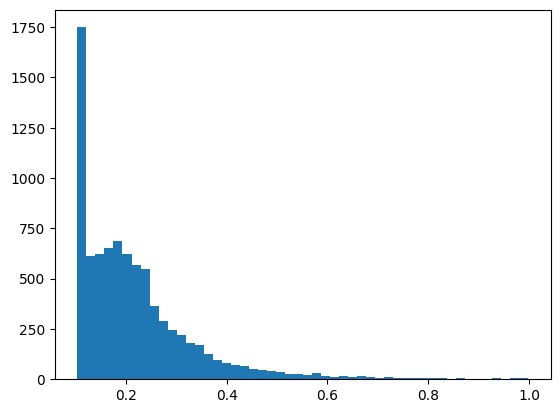

In [18]:
data=random_pixel_mask_batch(X_test,8)
game = parallelGame(data)
conf=game.evaluate(model,confidence_score)
plt.hist(conf,bins=50)

In [19]:
from sklearn import calibration as cal

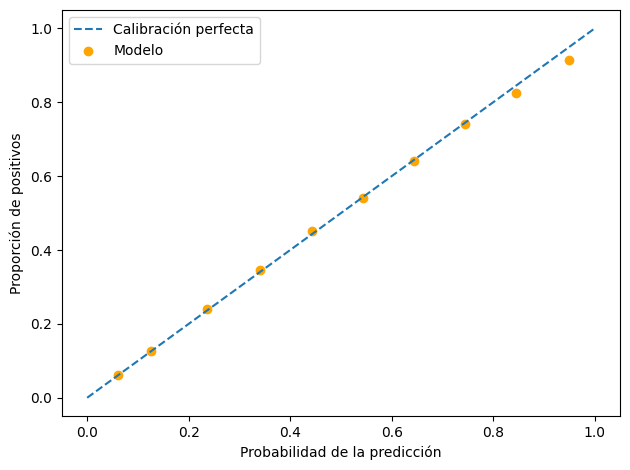

In [20]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

# Convert Y_test to one-hot encoding for categorical labels
categorical_labels = one_hot(Y_test, num_classes=10)
y_true = categorical_labels.reshape(-1)


# Initialize lists to accumulate all predictions and labels across iterations
all_y_true = []
all_y_probs = []

# Generate predictions for 10 random pixel batches
num_iterations = 100

with torch.no_grad():
    for _ in range(num_iterations):
        # Generate random pixel batch and predict
        random_batch = random_pixel_mask_batch(X_test, num_pixels=num_pixels).to(device)
        y_prob_batch = torch.softmax(model(random_batch).to("cpu"), dim=1).numpy()

        # Flatten and accumulate predictions
        y_prob_flat = y_prob_batch.reshape(-1)
        all_y_probs.extend(y_prob_flat)

        # Append true labels (same across iterations)
        all_y_true.extend(y_true)

# Convert accumulated lists to numpy arrays for calibration
all_y_true = np.array(all_y_true)
all_y_probs = np.array(all_y_probs)

# Calibration curve
prob_true, prob_pred = cal.calibration_curve(all_y_true, all_y_probs, n_bins=10)

# Plotting
plt.plot([0, 1], [0, 1], linestyle="--", label="Calibración perfecta")
plt.scatter(prob_pred, prob_true, color="orange", label="Modelo")
plt.xlabel("Probabilidad de la predicción")
plt.ylabel("Proporción de positivos")
plt.legend()
plt.tight_layout()
plt.savefig('Calibracion10Clases.png', dpi=300)
plt.show()


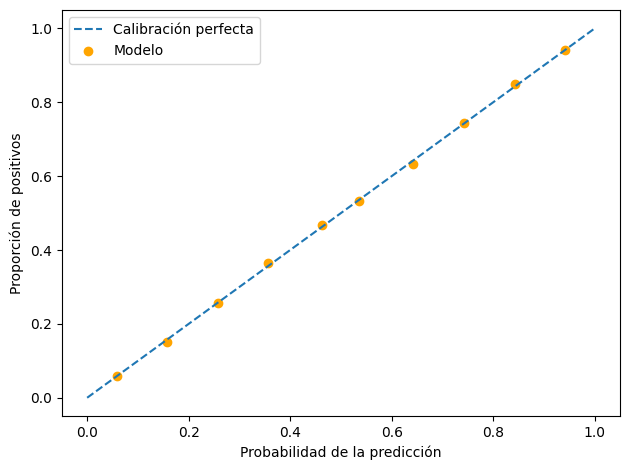

In [21]:
def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

# Convert Y_test to one-hot encoding for categorical labels
categorical_labels = one_hot(Y_test%2, num_classes=2)
y_true = categorical_labels.reshape(-1)


# Initialize lists to accumulate all predictions and labels across iterations
all_y_true = []
all_y_probs = []

# Generate predictions for 10 random pixel batches
num_iterations = 100

with torch.no_grad():
    for _ in range(num_iterations):
        # Generate random pixel batch and predict
        random_batch = random_pixel_mask_batch(X_test, num_pixels=num_pixels).to(device)
        y_prob_batch = torch.softmax(model(random_batch).to("cpu"), dim=1)
        y_prob_batch = torch.permute(torch.stack([y_prob_batch[:, [0, 2, 4, 6, 8]].sum(dim=1),y_prob_batch[:, [1, 3, 5, 7, 9]].sum(dim=1)]),(1,0)).numpy()
        # Flatten and accumulate predictions
        y_prob_flat = y_prob_batch.reshape(-1)
        all_y_probs.extend(y_prob_flat)

        # Append true labels (same across iterations)
        all_y_true.extend(y_true)

# Convert accumulated lists to numpy arrays for calibration
all_y_true = np.array(all_y_true)
all_y_probs = np.array(all_y_probs)

# Calibration curve
prob_true, prob_pred = cal.calibration_curve(all_y_true, all_y_probs, n_bins=10)

# Plotting
plt.plot([0, 1], [0, 1], linestyle="--", label="Calibración perfecta")
plt.scatter(prob_pred, prob_true, color="orange", label="Modelo")
plt.xlabel("Probabilidad de la predicción")
plt.ylabel("Proporción de positivos")
plt.legend()
plt.tight_layout()
plt.savefig('CalibracionEvenOdd.png', dpi=300)
plt.show()

In [22]:
import copy
class parallelGame:
    def __init__(self,game_tensor,data):
        self.tensor=game_tensor
        self.data=data
    def evaluate(self,model,metric):
        with torch.no_grad():
            return metric(model(self.tensor.to(device)).cpu())
    def add_pixel(self,pixels):
        # Get the dimensions of the batch (B is the batch size, C is the number of channels, H and W are the height and width of the images)
    
        B, C, H, W = self.tensor.shape
        rand_h = torch.tensor(pixels[0],dtype=torch.int)
        rand_w = torch.tensor(pixels[1],dtype=torch.int)
        # Generate random indices for height and width
        #rand_h = torch.randint(0, H, (B, 1, 1))
        #rand_w = torch.randint(0, W, (B, 1, 1))

        # Using broadcasting to select pixels from the batch at random indices for each image
        # Take random height (h) and width (w) coordinates for each image in the batch
        self.tensor[torch.arange(B), :, rand_h, rand_w] = self.data[torch.arange(B), :, rand_h, rand_w]
    def rollout(self,N,model,metric):
        B, C, H, W = self.tensor.shape
        rollout_game=copy.deepcopy(self)
        for i in range(N):
            rand_h = torch.randint(H, (B,))
            rand_w = torch.randint(W, (B,))
            pixels=np.array([rand_h,rand_w])
            rollout_game.add_pixel(pixels)
        return rollout_game.evaluate(model,metric)
class mcts:
    def __init__(self,game):
        self.game=game
        B, C, H, W = self.game.tensor.shape
        self.scores=torch.zeros(B,H,W)
        self.plays=torch.ones(B,H,W)*1e-9
        self.iters=0
        
    
    def search(self,N_turns,n_iters,model,metric,minimum=False):
        
        B, C, H, W = self.game.tensor.shape
        for i in range(n_iters):
            rand_h = torch.randint(H, (B,))
            rand_w = torch.randint(W, (B,))
            pixels=np.array([rand_h,rand_w])
            mcts_game=copy.deepcopy(self.game)
            mcts_game.add_pixel(pixels)
            
            self.scores[torch.arange(B), rand_h, rand_w]+=mcts_game.rollout(N_turns-1,model,metric)
            #self.scores[torch.arange(B), rand_h.squeeze(), rand_w.squeeze()]+=mcts_game.rollout(0,model,metric).squeeze()
            self.plays[torch.arange(B), rand_h, rand_w]+=torch.ones(B)
            self.iters+=1
        #uct=((self.scores/self.plays)+torch.sqrt(2*torch.log(torch.tensor(self.iters))/self.plays)).reshape(B,256)
        uct=(self.scores/self.plays)
        #torch.argmax(uct,dim=1)
        
        
        #print("UCT MAX",torch.amax(uct,dim=(1,2)))
        #mx=torch.argmax(uct,dim=1)
        #my=torch.argmax(uct[:,mx],dim=1)
        #print(uct[:,mx,my])
        #return torch.stack([torch.argmax(uct,dim=1)//16,torch.argmax(uct,dim=1)%16])
        #return torch.stack([mx,my])
        if(minimum):
            uct[self.plays==1e-9]=1e+9
            uct_r=uct.reshape((uct.shape[0],16*16))
            v1=torch.argmin(uct_r,dim=1)//16
            v2=torch.argmin(uct_r,dim=1)%16
        else:
            uct[self.plays==1e-9]=-1e+9
            uct_r=uct.reshape((uct.shape[0],16*16))
            v1=torch.argmax(uct_r,dim=1)//16
            v2=torch.argmax(uct_r,dim=1)%16
        #print("UCT MAX 0",uct[0,v1[0],v2[0]])
        return torch.stack([v1,v2])

/tmp/ipykernel_23/3907398009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_h = torch.tensor(pixels[0],dtype=torch.int)
/tmp/ipykernel_23/3907398009.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_w = torch.tensor(pixels[1],dtype=torch.int)


(array([ 25., 129., 290., 467., 595., 685., 696., 622., 566., 545., 427.,
        407., 356., 313., 267., 236., 204., 195., 155., 152., 150.,  92.,
        101.,  81.,  67.,  63.,  54.,  54.,  60.,  40.,  39.,  36.,  25.,
         33.,  25.,  21.,  24.,  12.,   9.,  13.,   7.,   5.,  14.,  10.,
          5.,   6.,   9.,   3.,   5.,   5.]),
 array([0.11359415, 0.1312905 , 0.14898685, 0.1666832 , 0.18437955,
        0.2020759 , 0.21977225, 0.2374686 , 0.25516495, 0.2728613 ,
        0.29055765, 0.308254  , 0.32595035, 0.34364671, 0.36134306,
        0.37903941, 0.39673576, 0.41443211, 0.43212846, 0.44982481,
        0.46752116, 0.48521751, 0.50291383, 0.52061021, 0.53830653,
        0.55600291, 0.57369924, 0.59139562, 0.60909194, 0.62678832,
        0.64448464, 0.66218102, 0.67987734, 0.69757372, 0.71527004,
        0.73296642, 0.75066274, 0.76835912, 0.78605545, 0.80375183,
        0.82144815, 0.83914453, 0.85684085, 0.87453723, 0.89223355,
        0.90992993, 0.92762625, 0.94532263, 0.

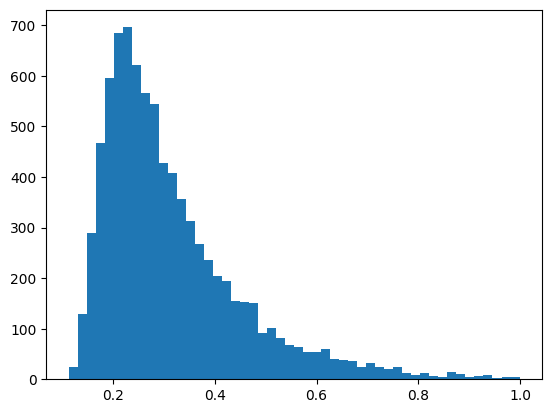

In [23]:
data=X_test
game_tensor=torch.ones_like(torch.Tensor(data))*-1
game = parallelGame(game_tensor,data)
for i in range(8):
    game.add_pixel(torch.randint(low=0,high=15,size=(2,data.shape[0])))
conf=game.evaluate(model,confidence_score)
plt.hist(conf,bins=50)

(array([ 59., 211., 360., 564., 671., 735., 710., 658., 606., 531., 445.,
        388., 330., 289., 250., 212., 151., 142., 134.,  95., 101.,  97.,
         89.,  68.,  60.,  46.,  54.,  41.,  27.,  30.,  35.,  31.,  26.,
         19.,  11.,  16.,   8.,  14.,  13.,   8.,   6.,  11.,  12.,   3.,
          4.,   8.,   4.,   4.,   4.,   9.]),
 array([0.1121427 , 0.12983795, 0.14753319, 0.16522844, 0.18292369,
        0.20061894, 0.21831419, 0.23600943, 0.25370467, 0.27139992,
        0.28909516, 0.30679041, 0.32448566, 0.34218091, 0.35987616,
        0.3775714 , 0.39526665, 0.4129619 , 0.43065715, 0.4483524 ,
        0.46604764, 0.48374289, 0.50143814, 0.51913339, 0.53682864,
        0.55452389, 0.57221913, 0.58991438, 0.60760963, 0.62530488,
        0.64300013, 0.66069537, 0.67839056, 0.69608581, 0.71378106,
        0.73147631, 0.74917156, 0.7668668 , 0.78456205, 0.8022573 ,
        0.81995255, 0.8376478 , 0.85534304, 0.87303829, 0.89073354,
        0.90842879, 0.92612404, 0.94381928, 0.

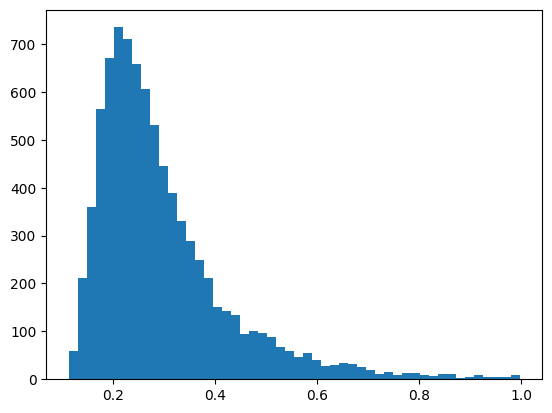

In [24]:
data=X_test
game_tensor=torch.ones_like(torch.Tensor(data))*-1
game = parallelGame(game_tensor,data)
player = mcts(game)
plt.hist(player.game.rollout(8,model,confidence_score),bins=50)

In [25]:
import torch
import torch.nn.functional as F
def entropy_score(results):
    # Compute softmax probabilities
    probs = torch.softmax(results, dim=1)
    # Calculate entropy
    entropy = -torch.sum(probs * torch.log(probs), dim=1)  # Adding a small constant to avoid log(0)
    return entropy
class CrossEntropyScore:
    def __init__(self, Y_test):
        """
        Initialize the class with the true labels (Y_test).

        Args:
            Y_test (list or tensor): A list or tensor of true labels (integers) between 0 and 9.
        """
        self.Y_test = torch.tensor(Y_test)
        
    def __call__(self, results):
        """
        Compute the cross-entropy score.

        Args:
            results (tensor): A tensor of model outputs (logits), with shape (N, C), where:
                              N is the number of samples and C is the number of classes.
        
        Returns:
            Tensor: A tensor containing the cross-entropy score for each sample.
        """
        # Compute softmax probabilities
        probs = F.softmax(results, dim=1)

        # Convert Y_test to one-hot encoding
        Y_one_hot = F.one_hot(self.Y_test, num_classes=probs.shape[1]).float()

        # Calculate the cross-entropy score
        cross_entropy = -torch.sum(Y_one_hot * torch.log(probs), dim=1)  # Add small constant to avoid log(0)
        
        return cross_entropy

In [26]:
def even_odd_entropy(results):
    """
    Compute the entropy score by classifying even vs. odd numbers.

    Args:
        results (tensor): A tensor of model outputs (logits), with shape (N, 10), where N is the number of samples
                          and 10 represents the 10 digits (0-9).

    Returns:
        Tensor: A tensor containing the entropy score for even and odd classification for each sample.
    """
    # Compute softmax probabilities
    probs = torch.softmax(results, dim=1)
    
    # Sum probabilities for even and odd numbers
    odd_probs = probs[:, [1, 3, 5, 7, 9]].sum(dim=1)
    even_probs = probs[:, [0, 2, 4, 6, 8]].sum(dim=1)
    
    # Stack odd and even probabilities to shape (N, 2)
    combined_probs = torch.stack([odd_probs, even_probs], dim=1)
    
    # Calculate entropy
    entropy = -torch.sum(combined_probs * torch.log(combined_probs), dim=1)
    
    return entropy
class EvenOddCrossEntropyScore:
    def __init__(self, Y_test):
        """
        Initialize the class with the true labels (Y_test).

        Args:
            Y_test (list or tensor): A list or tensor of true labels (integers) between 0 and 9.
        """
        self.Y_test = torch.tensor(Y_test)
        
    def __call__(self, results):
        """
        Compute the cross-entropy score for even vs. odd classification.

        Args:
            results (tensor): A tensor of model outputs (logits), with shape (N, 10), where:
                              N is the number of samples and 10 represents the 10 digits (0-9).
        
        Returns:
            Tensor: A tensor containing the cross-entropy score for even and odd classification for each sample.
        """
        # Compute softmax probabilities
        probs = torch.softmax(results, dim=1)

        # Sum probabilities for even and odd numbers
        odd_probs = probs[:, [1, 3, 5, 7, 9]].sum(dim=1)
        even_probs = probs[:, [0, 2, 4, 6, 8]].sum(dim=1)
        
        # Stack odd and even probabilities to shape (N, 2)
        combined_probs = torch.stack([odd_probs, even_probs], dim=1)
        
        # Create labels: 0 for even, 1 for odd
        Y_even_odd = (self.Y_test % 2 == 0).long()  # 0 for odd, 1 for even, 

        # Convert to one-hot encoding
        Y_even_odd_one_hot = F.one_hot(Y_even_odd, num_classes=2).float()

        # Calculate the cross-entropy score
        cross_entropy = -torch.sum(Y_even_odd_one_hot * torch.log(combined_probs), dim=1)
        
        return cross_entropy
    

def even_odd_confidence(results):
    
    # Compute softmax probabilities
    probs = torch.softmax(results, dim=1)
    
    # Sum probabilities for even and odd numbers
    odd_probs = probs[:, [1, 3, 5, 7, 9]].sum(dim=1)
    even_probs = probs[:, [0, 2, 4, 6, 8]].sum(dim=1)
    
    # Stack odd and even probabilities to shape (N, 2)
    combined_probs = torch.stack([odd_probs, even_probs], dim=1)
    
    # Calculate entropy
    confidence = torch.max(combined_probs, dim=1)[0]
    
    return confidence

class EvenOddAccuracyScore:
    def __init__(self, Y_test):
        """
        Initialize the class with the true labels (Y_test).

        Args:
            Y_test (list or tensor): A list or tensor of true labels (integers) between 0 and 9.
        """
        self.Y_test = torch.tensor(Y_test)
        
    def __call__(self, results):
        """
        Compute the accuracy score for even vs. odd classification.

        Args:
            results (tensor): A tensor of model outputs (logits), with shape (N, 10), where:
                              N is the number of samples and 10 represents the 10 digits (0-9).
        
        Returns:
            float: The accuracy score for even and odd classification.
        """
        # Compute softmax probabilities
        probs = torch.softmax(results, dim=1)

        # Sum probabilities for even and odd numbers
        odd_probs = probs[:, [1, 3, 5, 7, 9]].sum(dim=1)
        even_probs = probs[:, [0, 2, 4, 6, 8]].sum(dim=1)
        
        # Stack odd and even probabilities to shape (N, 2)
        combined_probs = torch.stack([odd_probs, even_probs], dim=1)
        
        # Create labels: 0 for even, 1 for odd
        Y_even_odd = (self.Y_test % 2 == 0).long()  # 0 for odd, 1 for even, 

        # Calculate the cross-entropy score
        accuracy = (torch.argmax(combined_probs, dim=1) == Y_even_odd).float()
        
        return accuracy


In [27]:
def evalRLHF(n, num_pixels, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence):
    data=X_test
    game_tensor=torch.ones_like(torch.Tensor(data))*-1
    game = parallelGame(game_tensor,data)

    for i in range(num_pixels):
        player = mcts(game)
        pixels=player.search(num_pixels-i,n,model,even_odd_entropy,minimum=True)
        game.add_pixel(pixels)
        
    return torch.mean(game.evaluate(model,even_odd_entropy)),torch.mean(game.evaluate(model,ce_even_odd)),torch.mean(game.evaluate(model,even_odd_confidence)),torch.mean(game.evaluate(model,acc_even_odd))

In [28]:
def plot_confidence(num_pixels):
    ce_even_odd = EvenOddCrossEntropyScore(Y_test)
    acc_even_odd = EvenOddAccuracyScore(Y_test)

    steps=np.ceil(np.logspace(0,np.log10(1000),15))
    print(steps)
    entropies_eo=[]
    crossentropies_eo=[]
    confidences_eo=[]
    accuracies_eo=[]
    for i in range(len(steps)):
        k=evalRLHF(int(steps[i]),num_pixels, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence)
        print(k)
        entropies_eo.append(k[0])
        crossentropies_eo.append(k[1])
        confidences_eo.append(k[2])
        accuracies_eo.append(k[3])
    # Plotting with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # First subplot: Negative Entropy and Negative Cross-Entropy with Deuteranomaly-friendly colors
    ax1.scatter(steps, [-ce for ce in crossentropies_eo], color='#ff7f0e', label='Cross-Entropy negativa')  # Orange
    ax1.plot(steps, [-ce for ce in crossentropies_eo], color='#ff7f0e')
    ax1.scatter(steps, [-e for e in entropies_eo], color='#1f77b4', label='Entropy negativa')       # Dark Blue
    ax1.plot(steps, [-e for e in entropies_eo], color='#1f77b4')
    ax1.set_xscale('log')
    ax1.set_xlabel('Cantidad de pasos de búsqueda')
    ax1.set_ylabel('Cross-Entropy negativa y Entropy negativa')
    ax1.legend()

    # Second subplot: Confidence and Accuracy with Deuteranomaly-friendly colors
    ax2.scatter(steps, accuracies_eo, color='#ff7f0e', label='Precisión')     # Teal
    ax2.plot(steps, accuracies_eo, color='#ff7f0e')
    ax2.scatter(steps, confidences_eo, color='#1f77b4', label='Confianza')  # Purple
    ax2.plot(steps, confidences_eo, color='#1f77b4')
    ax2.set_xscale('log')
    ax2.set_xlabel('Cantidad de pasos de búsqueda')
    ax2.set_ylabel('Precisión y Confianza')
    ax2.legend()
    plt.tight_layout()
    plt.savefig('Maximizar_Confianza_'+str(num_pixels)+'_pixeles.png', dpi=300)
    plt.show()

/tmp/ipykernel_23/606736386.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/606736386.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/3907398009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_h = torch.tensor(pixels[0],dtype=torch.int)
/tmp/ipykernel_23/3907398009.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6818), tensor(0.6833), tensor(0.5457), tensor(0.5412))
(tensor(0.6732), tensor(0.6728), tensor(0.5700), tensor(0.5648))
(tensor(0.6641), tensor(0.6617), tensor(0.5903), tensor(0.5912))
(tensor(0.6509), tensor(0.6541), tensor(0.6165), tensor(0.6035))
(tensor(0.6350), tensor(0.6338), tensor(0.6429), tensor(0.6400))
(tensor(0.6163), tensor(0.6263), tensor(0.6685), tensor(0.6539))
(tensor(0.5898), tensor(0.5904), tensor(0.7001), tensor(0.6940))
(tensor(0.5630), tensor(0.5700), tensor(0.7280), tensor(0.7169))
(tensor(0.5310), tensor(0.5473), tensor(0.7578), tensor(0.7402))
(tensor(0.4985), tensor(0.5279), tensor(0.7841), tensor(0.7567))
(tensor(0.4667), tensor(0.5040), tensor(0.8064), tensor(0.7774))
(tensor(0.4381), tensor(0.4886), tensor(0.8252), tensor(0.7868))
(tensor(0.4173), tensor(0.4813), tensor(0.8386), tensor(0.7915))
(tensor(0.4027), tensor(0.4721), tensor(0.8473), tensor(0.7987

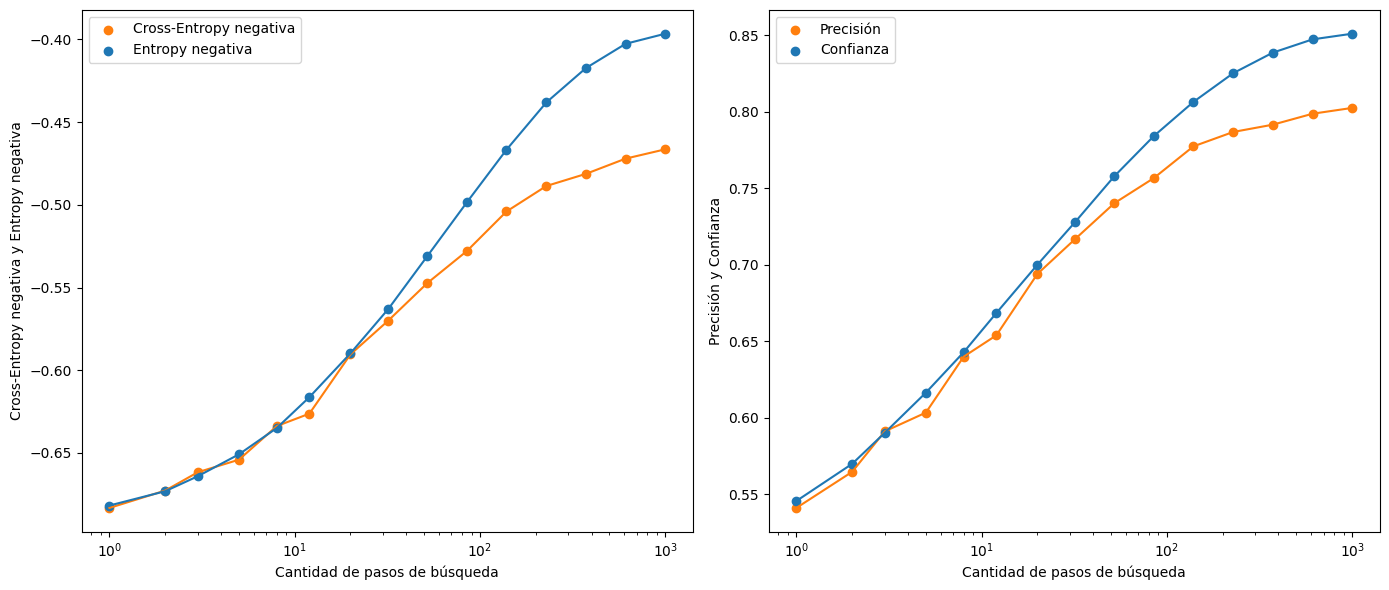

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6721), tensor(0.6711), tensor(0.5692), tensor(0.5657))
(tensor(0.6533), tensor(0.6543), tensor(0.6080), tensor(0.5979))
(tensor(0.6347), tensor(0.6505), tensor(0.6366), tensor(0.6140))
(tensor(0.6097), tensor(0.6240), tensor(0.6704), tensor(0.6467))
(tensor(0.5805), tensor(0.6055), tensor(0.7030), tensor(0.6701))
(tensor(0.5508), tensor(0.5861), tensor(0.7325), tensor(0.6929))
(tensor(0.5063), tensor(0.5650), tensor(0.7695), tensor(0.7196))
(tensor(0.4660), tensor(0.5501), tensor(0.8000), tensor(0.7424))
(tensor(0.4229), tensor(0.5275), tensor(0.8284), tensor(0.7620))
(tensor(0.3829), tensor(0.5131), tensor(0.8531), tensor(0.7813))
(tensor(0.3430), tensor(0.5108), tensor(0.8754), tensor(0.7907))
(tensor(0.3104), tensor(0.5213), tensor(0.8923), tensor(0.7935))
(tensor(0.2820), tensor(0.5066), tensor(0.9061), tensor(0.8074))
(tensor(0.2596), tensor(0.5135), tensor(0.9166), tensor(0.8080

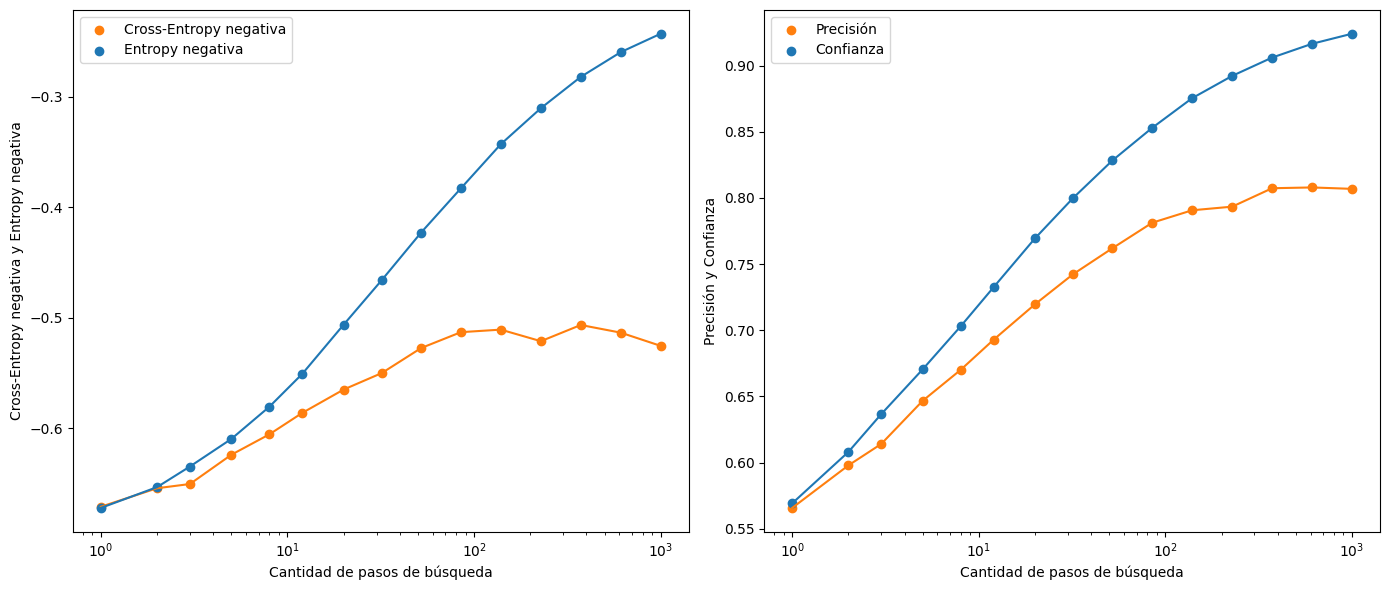

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6520), tensor(0.6492), tensor(0.6054), tensor(0.6069))
(tensor(0.6143), tensor(0.6347), tensor(0.6603), tensor(0.6318))
(tensor(0.5841), tensor(0.6199), tensor(0.6952), tensor(0.6483))
(tensor(0.5426), tensor(0.6013), tensor(0.7357), tensor(0.6802))
(tensor(0.4944), tensor(0.5679), tensor(0.7755), tensor(0.7143))
(tensor(0.4539), tensor(0.5591), tensor(0.8046), tensor(0.7355))
(tensor(0.3974), tensor(0.5545), tensor(0.8411), tensor(0.7498))
(tensor(0.3518), tensor(0.5297), tensor(0.8677), tensor(0.7758))
(tensor(0.3126), tensor(0.5292), tensor(0.8881), tensor(0.7863))
(tensor(0.2679), tensor(0.5373), tensor(0.9102), tensor(0.7995))
(tensor(0.2305), tensor(0.5632), tensor(0.9272), tensor(0.7963))
(tensor(0.2037), tensor(0.5615), tensor(0.9385), tensor(0.8075))
(tensor(0.1780), tensor(0.5772), tensor(0.9488), tensor(0.8112))
(tensor(0.1565), tensor(0.6024), tensor(0.9567), tensor(0.8119

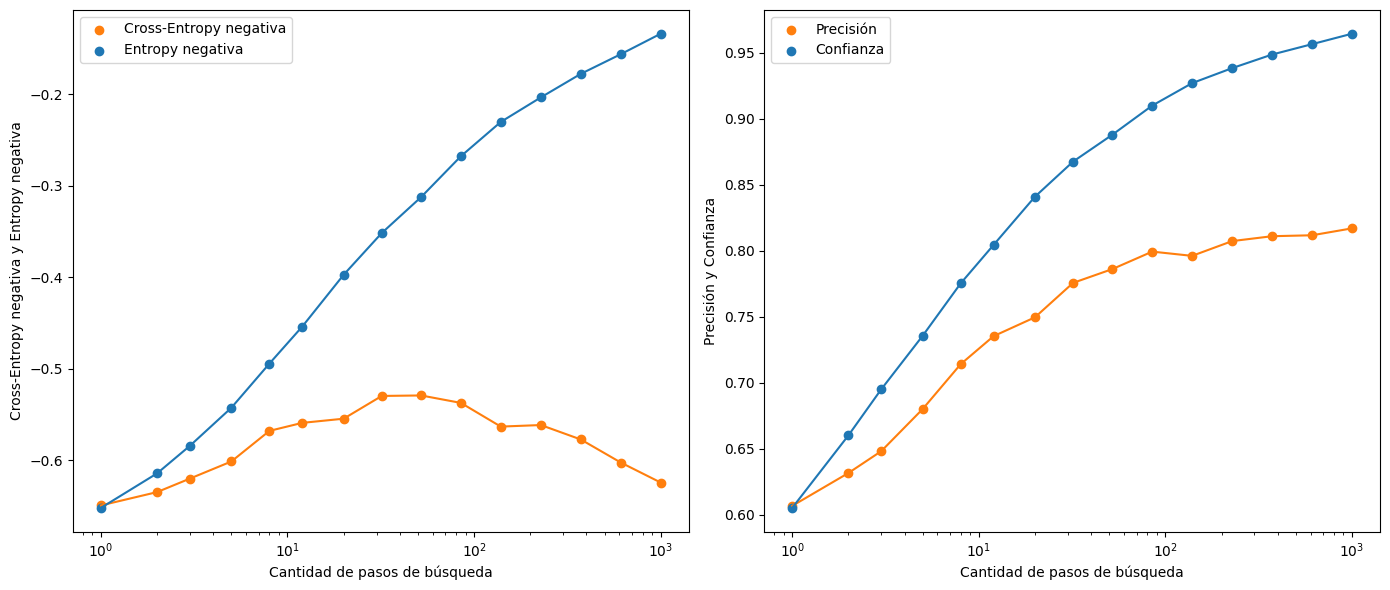

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6197), tensor(0.6237), tensor(0.6480), tensor(0.6410))
(tensor(0.5516), tensor(0.5865), tensor(0.7232), tensor(0.6845))
(tensor(0.5059), tensor(0.5718), tensor(0.7634), tensor(0.7031))
(tensor(0.4460), tensor(0.5608), tensor(0.8079), tensor(0.7294))
(tensor(0.3902), tensor(0.5399), tensor(0.8437), tensor(0.7560))
(tensor(0.3427), tensor(0.5599), tensor(0.8704), tensor(0.7608))
(tensor(0.2886), tensor(0.5604), tensor(0.8984), tensor(0.7789))
(tensor(0.2424), tensor(0.5680), tensor(0.9200), tensor(0.7895))
(tensor(0.2061), tensor(0.5920), tensor(0.9360), tensor(0.7933))
(tensor(0.1716), tensor(0.5945), tensor(0.9501), tensor(0.8094))
(tensor(0.1444), tensor(0.6179), tensor(0.9603), tensor(0.8126))
(tensor(0.1240), tensor(0.6330), tensor(0.9677), tensor(0.8177))
(tensor(0.1093), tensor(0.6419), tensor(0.9725), tensor(0.8223))
(tensor(0.0926), tensor(0.6908), tensor(0.9777), tensor(0.8194

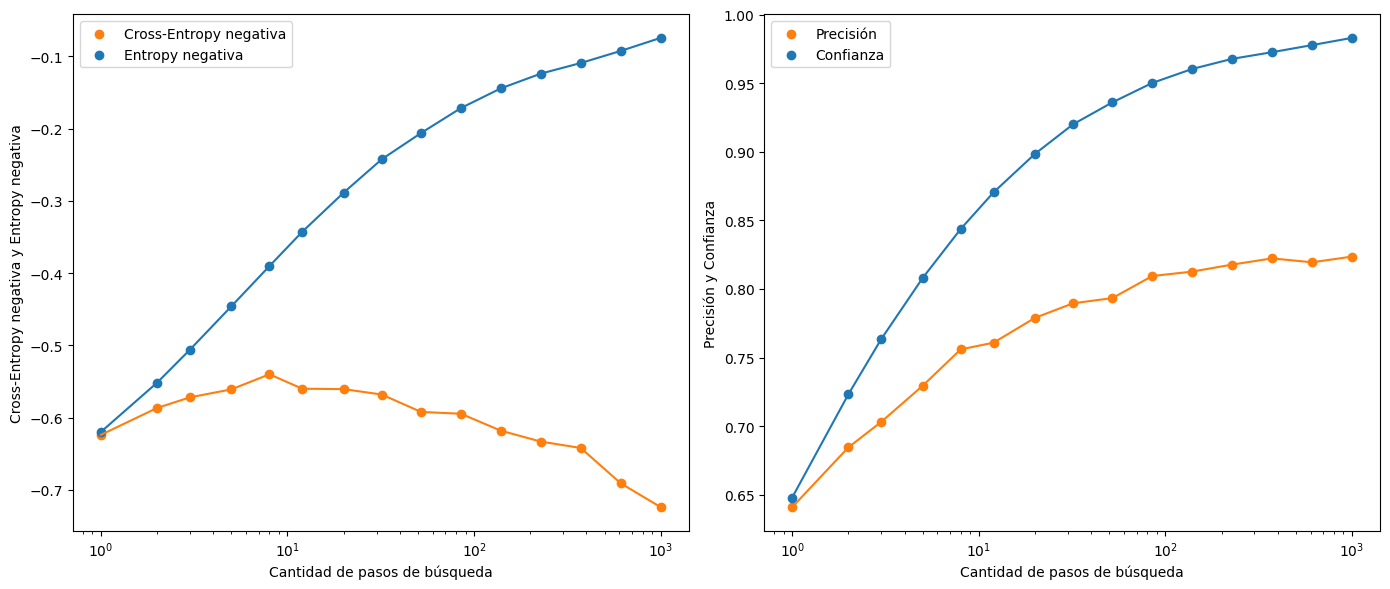

In [29]:
plot_confidence(1)
plot_confidence(2)
plot_confidence(4)
plot_confidence(8)

In [30]:
import copy
def maximizarCrossEntropy(n, num_pixels, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence):
    data=X_test
    game_tensor=torch.ones_like(torch.Tensor(data))*-1
    game = parallelGame(game_tensor,data)

    for i in range(num_pixels):
        player = mcts(game)
        pixels=player.search(num_pixels-i,n,model,ce_even_odd,minimum=True)
        game.add_pixel(pixels)
        
    return torch.mean(game.evaluate(model,even_odd_entropy)),torch.mean(game.evaluate(model,ce_even_odd)),torch.mean(game.evaluate(model,even_odd_confidence)),torch.mean(game.evaluate(model,acc_even_odd))

def maximizarCrossEntropyOpuesto(n, num_pixels, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence):
    data=X_test
    game_tensor=torch.ones_like(torch.Tensor(data))*-1
    game = parallelGame(game_tensor,data)
    ce_even_odd_neg=copy.deepcopy(ce_even_odd)
    ce_even_odd_neg.Y_test=9-ce_even_odd_neg.Y_test
    
    for i in range(num_pixels):
        player = mcts(game)
        pixels=player.search(num_pixels-i,n,model,ce_even_odd_neg,minimum=True)
        game.add_pixel(pixels)
        
    return torch.mean(game.evaluate(model,even_odd_entropy)),torch.mean(game.evaluate(model,ce_even_odd)),torch.mean(game.evaluate(model,even_odd_confidence)),torch.mean(game.evaluate(model,acc_even_odd))

def plot_maximizar_ce(num_pixels):
    ce_even_odd = EvenOddCrossEntropyScore(Y_test)
    acc_even_odd = EvenOddAccuracyScore(Y_test)

    steps=np.ceil(np.logspace(0,np.log10(1000),15))
    print(steps)
    entropies_eo=[]
    crossentropies_eo=[]
    confidences_eo=[]
    accuracies_eo=[]
    for i in range(len(steps)):
        k=maximizarCrossEntropy(int(steps[i]),num_pixels, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence)
        print(k)
        entropies_eo.append(k[0])
        crossentropies_eo.append(k[1])
        confidences_eo.append(k[2])
        accuracies_eo.append(k[3])
    # Plotting with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # First subplot: Negative Entropy and Negative Cross-Entropy with Deuteranomaly-friendly colors
    ax1.scatter(steps, [-ce for ce in crossentropies_eo], color='#ff7f0e', label='Cross-Entropy negativa')  # Orange
    ax1.plot(steps, [-ce for ce in crossentropies_eo], color='#ff7f0e')
    ax1.scatter(steps, [-e for e in entropies_eo], color='#1f77b4', label='Entropy negativa')       # Dark Blue
    ax1.plot(steps, [-e for e in entropies_eo], color='#1f77b4')
    ax1.set_xscale('log')
    ax1.set_xlabel('Cantidad de pasos de búsqueda')
    ax1.set_ylabel('Cross-Entropy negativa y Entropy negativa')
    ax1.legend()

    # Second subplot: Confidence and Accuracy with Deuteranomaly-friendly colors
    ax2.scatter(steps, accuracies_eo, color='#ff7f0e', label='Precisión')     # Teal
    ax2.plot(steps, accuracies_eo, color='#ff7f0e')
    ax2.scatter(steps, confidences_eo, color='#1f77b4', label='Confianza')  # Purple
    ax2.plot(steps, confidences_eo, color='#1f77b4')
    ax2.set_xscale('log')
    ax2.set_xlabel('Cantidad de pasos de búsqueda')
    ax2.set_ylabel('Precisión y Confianza')
    ax2.legend()
    plt.tight_layout()
    plt.savefig('Maximizar_CrossEntropy_'+str(num_pixels)+'_pixeles.png', dpi=300)
    plt.show()

def plot_maximizar_ce_opuesto(num_pixels):
    ce_even_odd = EvenOddCrossEntropyScore(Y_test)
    acc_even_odd = EvenOddAccuracyScore(Y_test)

    steps=np.ceil(np.logspace(0,np.log10(1000),15))
    print(steps)
    entropies_eo=[]
    crossentropies_eo=[]
    confidences_eo=[]
    accuracies_eo=[]
    for i in range(len(steps)):
        k=maximizarCrossEntropyOpuesto(int(steps[i]),num_pixels, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence)
        print(k)
        entropies_eo.append(k[0])
        crossentropies_eo.append(k[1])
        confidences_eo.append(k[2])
        accuracies_eo.append(k[3])
    # Plotting with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # First subplot: Negative Entropy and Negative Cross-Entropy with Deuteranomaly-friendly colors
    ax1.scatter(steps, [-ce for ce in crossentropies_eo], color='#ff7f0e', label='Cross-Entropy negativa')  # Orange
    ax1.plot(steps, [-ce for ce in crossentropies_eo], color='#ff7f0e')
    ax1.scatter(steps, [-e for e in entropies_eo], color='#1f77b4', label='Entropy negativa')       # Dark Blue
    ax1.plot(steps, [-e for e in entropies_eo], color='#1f77b4')
    ax1.set_xscale('log')
    ax1.set_xlabel('Cantidad de pasos de búsqueda')
    ax1.set_ylabel('Cross-Entropy negativa y Entropy negativa')
    ax1.legend()

    # Second subplot: Confidence and Accuracy with Deuteranomaly-friendly colors
    ax2.scatter(steps, accuracies_eo, color='#ff7f0e', label='Precisión')     # Teal
    ax2.plot(steps, accuracies_eo, color='#ff7f0e')
    ax2.scatter(steps, confidences_eo, color='#1f77b4', label='Confianza')  # Purple
    ax2.plot(steps, confidences_eo, color='#1f77b4')
    ax2.set_xscale('log')
    ax2.set_xlabel('Cantidad de pasos de búsqueda')
    ax2.set_ylabel('Precisión y Confianza')
    ax2.legend()
    plt.tight_layout()
    plt.savefig('Maximizar_CrossEntropy_Opuesto'+str(num_pixels)+'_pixeles.png', dpi=300)
    plt.show()

/tmp/ipykernel_23/606736386.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/606736386.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/3907398009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_h = torch.tensor(pixels[0],dtype=torch.int)
/tmp/ipykernel_23/3907398009.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6827), tensor(0.6823), tensor(0.5448), tensor(0.5487))
(tensor(0.6780), tensor(0.6190), tensor(0.5526), tensor(0.7236))
(tensor(0.6726), tensor(0.5880), tensor(0.5648), tensor(0.8025))
(tensor(0.6590), tensor(0.5378), tensor(0.5917), tensor(0.8996))
(tensor(0.6482), tensor(0.4999), tensor(0.6134), tensor(0.9531))
(tensor(0.6316), tensor(0.4568), tensor(0.6401), tensor(0.9844))
(tensor(0.6050), tensor(0.4042), tensor(0.6746), tensor(0.9986))
(tensor(0.5794), tensor(0.3589), tensor(0.7053), tensor(1.))
(tensor(0.5481), tensor(0.3142), tensor(0.7368), tensor(1.))
(tensor(0.5164), tensor(0.2758), tensor(0.7649), tensor(1.))
(tensor(0.4858), tensor(0.2444), tensor(0.7887), tensor(1.))
(tensor(0.4577), tensor(0.2186), tensor(0.8088), tensor(1.))
(tensor(0.4361), tensor(0.2007), tensor(0.8231), tensor(1.))
(tensor(0.4225), tensor(0.1897), tensor(0.8319), tensor(1.))
(tensor(0.4162), tensor(0

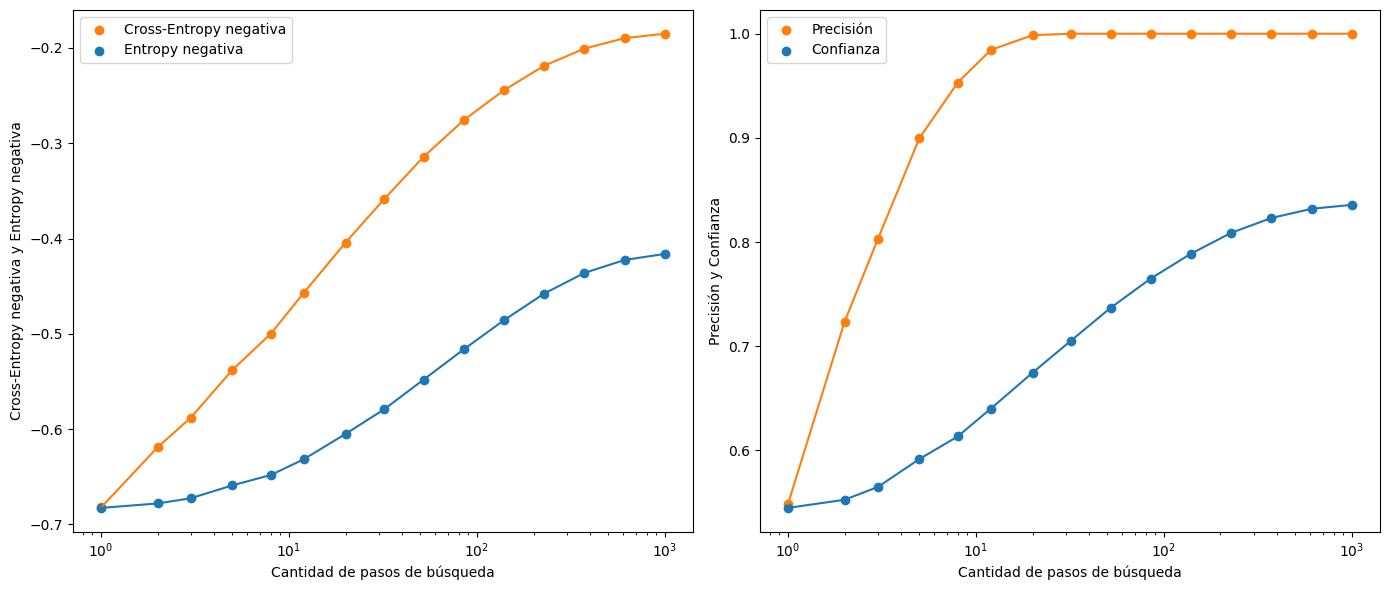

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6820), tensor(0.6834), tensor(0.5453), tensor(0.5419))
(tensor(0.6861), tensor(0.7450), tensor(0.5377), tensor(0.3719))
(tensor(0.6842), tensor(0.7765), tensor(0.5433), tensor(0.2719))
(tensor(0.6800), tensor(0.8168), tensor(0.5565), tensor(0.1729))
(tensor(0.6738), tensor(0.8624), tensor(0.5727), tensor(0.0926))
(tensor(0.6679), tensor(0.9032), tensor(0.5883), tensor(0.0424))
(tensor(0.6573), tensor(0.9653), tensor(0.6109), tensor(0.0070))
(tensor(0.6476), tensor(1.0172), tensor(0.6299), tensor(0.0011))
(tensor(0.6334), tensor(1.0839), tensor(0.6514), tensor(0.))
(tensor(0.6192), tensor(1.1488), tensor(0.6719), tensor(0.))
(tensor(0.6058), tensor(1.2059), tensor(0.6891), tensor(0.))
(tensor(0.5931), tensor(1.2583), tensor(0.7037), tensor(0.))
(tensor(0.5835), tensor(1.2983), tensor(0.7142), tensor(0.))
(tensor(0.5777), tensor(1.3219), tensor(0.7203), tensor(0.))
(tensor(0.5751), tens

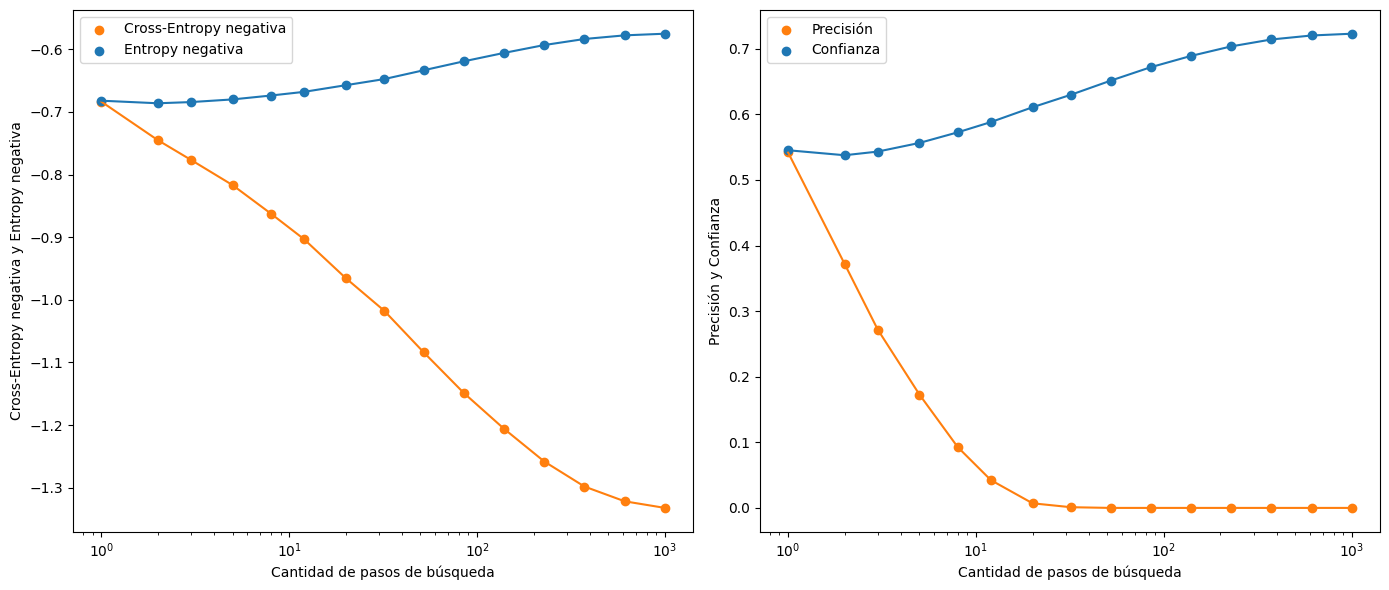

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6720), tensor(0.6719), tensor(0.5693), tensor(0.5711))
(tensor(0.6597), tensor(0.5687), tensor(0.5873), tensor(0.7882))
(tensor(0.6461), tensor(0.5199), tensor(0.6093), tensor(0.8675))
(tensor(0.6211), tensor(0.4576), tensor(0.6456), tensor(0.9319))
(tensor(0.5915), tensor(0.3994), tensor(0.6818), tensor(0.9701))
(tensor(0.5636), tensor(0.3544), tensor(0.7120), tensor(0.9845))
(tensor(0.5201), tensor(0.2987), tensor(0.7516), tensor(0.9932))
(tensor(0.4793), tensor(0.2532), tensor(0.7847), tensor(0.9979))
(tensor(0.4412), tensor(0.2173), tensor(0.8121), tensor(0.9990))
(tensor(0.3986), tensor(0.1813), tensor(0.8403), tensor(1.))
(tensor(0.3635), tensor(0.1547), tensor(0.8618), tensor(0.9999))
(tensor(0.3305), tensor(0.1325), tensor(0.8801), tensor(1.))
(tensor(0.3030), tensor(0.1161), tensor(0.8940), tensor(1.))
(tensor(0.2826), tensor(0.1045), tensor(0.9040), tensor(1.))
(tensor(0.265

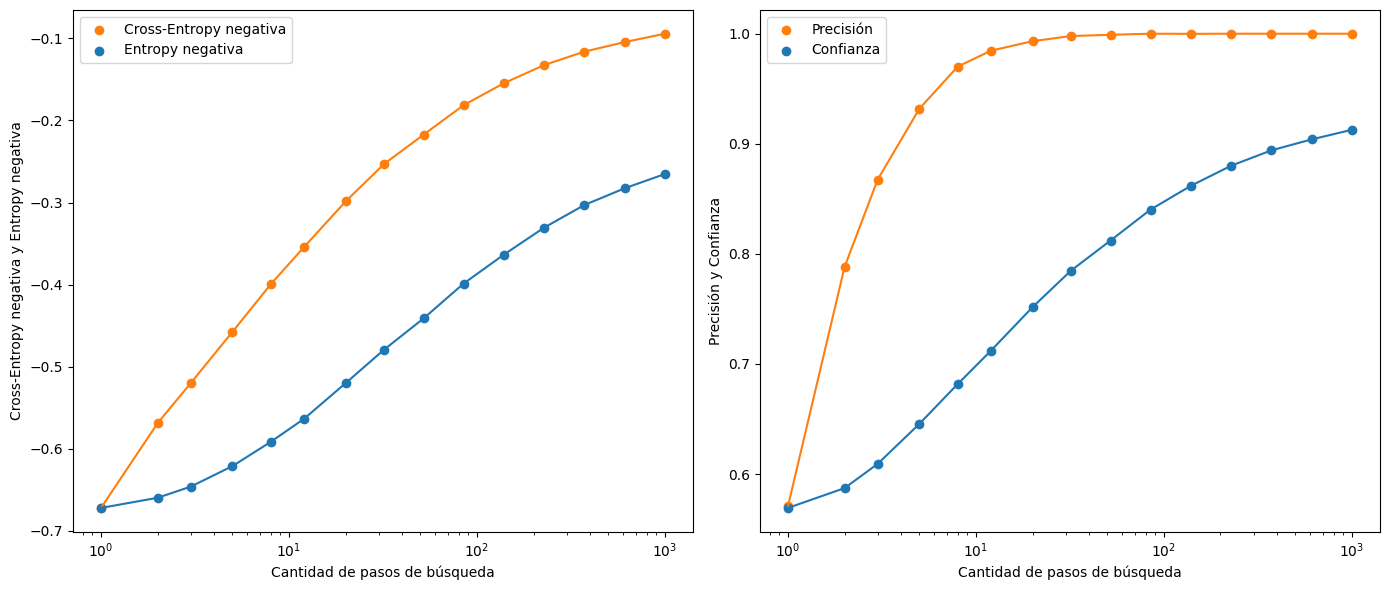

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6711), tensor(0.6669), tensor(0.5702), tensor(0.5796))
(tensor(0.6789), tensor(0.7795), tensor(0.5596), tensor(0.3374))
(tensor(0.6737), tensor(0.8360), tensor(0.5693), tensor(0.2243))
(tensor(0.6648), tensor(0.9014), tensor(0.5888), tensor(0.1244))
(tensor(0.6512), tensor(0.9800), tensor(0.6150), tensor(0.0595))
(tensor(0.6394), tensor(1.0400), tensor(0.6343), tensor(0.0296))
(tensor(0.6191), tensor(1.1357), tensor(0.6635), tensor(0.0156))
(tensor(0.5968), tensor(1.2331), tensor(0.6913), tensor(0.0070))
(tensor(0.5754), tensor(1.3246), tensor(0.7150), tensor(0.0029))
(tensor(0.5528), tensor(1.4172), tensor(0.7370), tensor(0.0013))
(tensor(0.5304), tensor(1.5095), tensor(0.7580), tensor(0.0002))
(tensor(0.5104), tensor(1.5923), tensor(0.7751), tensor(0.))
(tensor(0.4928), tensor(1.6641), tensor(0.7890), tensor(0.))
(tensor(0.4776), tensor(1.7263), tensor(0.8004), tensor(0.0001))
(tens

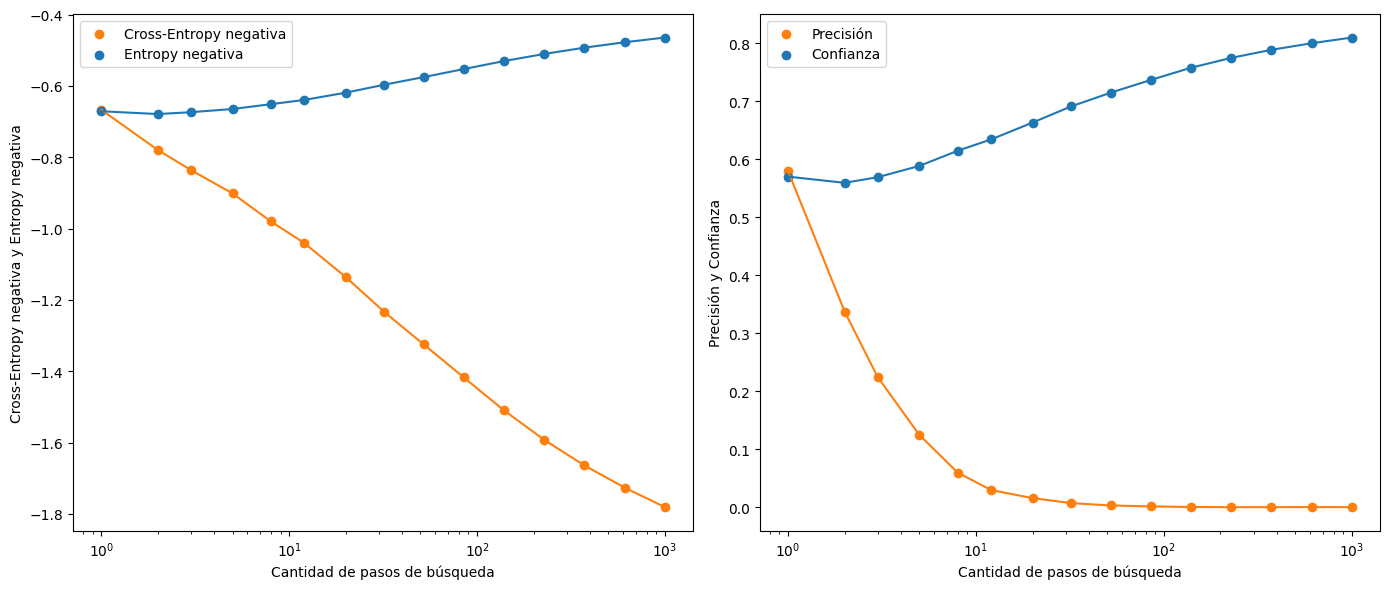

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6512), tensor(0.6497), tensor(0.6059), tensor(0.6030))
(tensor(0.6267), tensor(0.4999), tensor(0.6372), tensor(0.8304))
(tensor(0.5968), tensor(0.4314), tensor(0.6710), tensor(0.9024))
(tensor(0.5535), tensor(0.3569), tensor(0.7165), tensor(0.9530))
(tensor(0.5106), tensor(0.3012), tensor(0.7544), tensor(0.9742))
(tensor(0.4655), tensor(0.2517), tensor(0.7893), tensor(0.9860))
(tensor(0.4146), tensor(0.2035), tensor(0.8252), tensor(0.9938))
(tensor(0.3665), tensor(0.1661), tensor(0.8548), tensor(0.9965))
(tensor(0.3238), tensor(0.1361), tensor(0.8789), tensor(0.9987))
(tensor(0.2828), tensor(0.1089), tensor(0.9012), tensor(0.9994))
(tensor(0.2492), tensor(0.0900), tensor(0.9173), tensor(0.9999))
(tensor(0.2214), tensor(0.0755), tensor(0.9298), tensor(1.))
(tensor(0.1987), tensor(0.0649), tensor(0.9393), tensor(1.))
(tensor(0.1751), tensor(0.0541), tensor(0.9489), tensor(1.))
(tensor(0

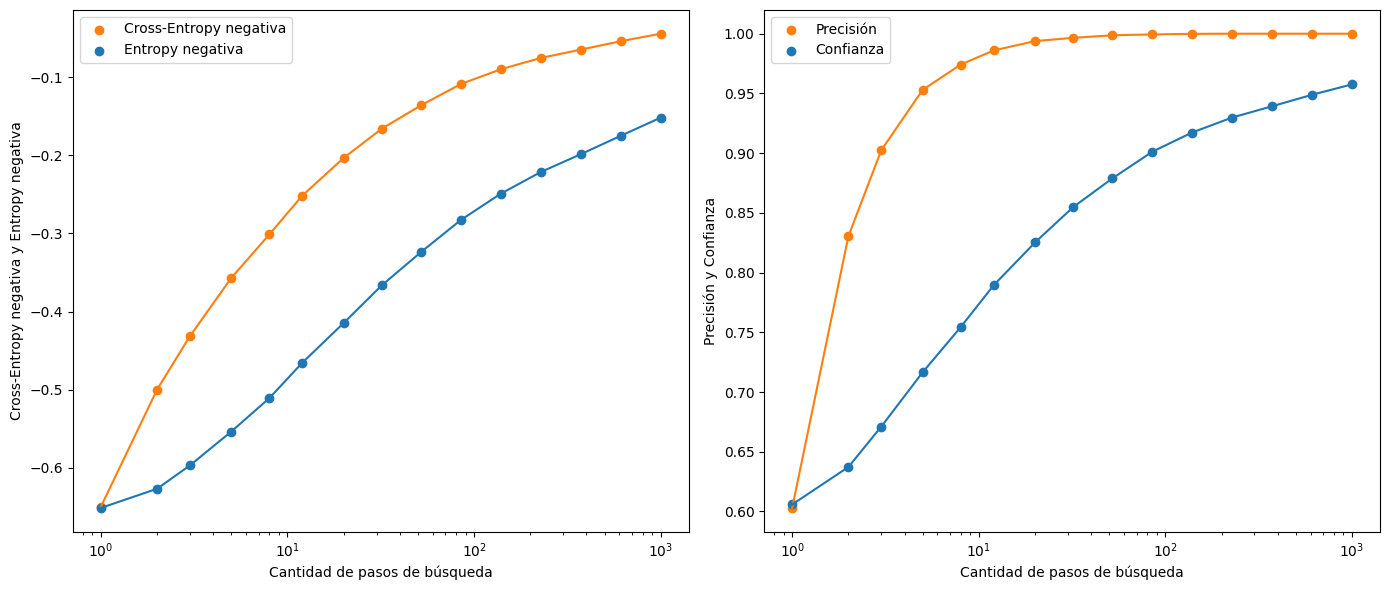

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6520), tensor(0.6531), tensor(0.6052), tensor(0.6030))
(tensor(0.6636), tensor(0.8299), tensor(0.5911), tensor(0.3311))
(tensor(0.6553), tensor(0.9181), tensor(0.6037), tensor(0.2101))
(tensor(0.6361), tensor(1.0330), tensor(0.6335), tensor(0.1101))
(tensor(0.6129), tensor(1.1445), tensor(0.6645), tensor(0.0615))
(tensor(0.5905), tensor(1.2485), tensor(0.6922), tensor(0.0308))
(tensor(0.5603), tensor(1.3797), tensor(0.7238), tensor(0.0175))
(tensor(0.5307), tensor(1.5046), tensor(0.7513), tensor(0.0065))
(tensor(0.4980), tensor(1.6428), tensor(0.7787), tensor(0.0042))
(tensor(0.4700), tensor(1.7642), tensor(0.8006), tensor(0.0014))
(tensor(0.4402), tensor(1.8945), tensor(0.8217), tensor(0.0004))
(tensor(0.4169), tensor(1.9957), tensor(0.8373), tensor(0.0005))
(tensor(0.3920), tensor(2.1121), tensor(0.8526), tensor(0.0002))
(tensor(0.3707), tensor(2.2168), tensor(0.8650), tensor(0.))
(

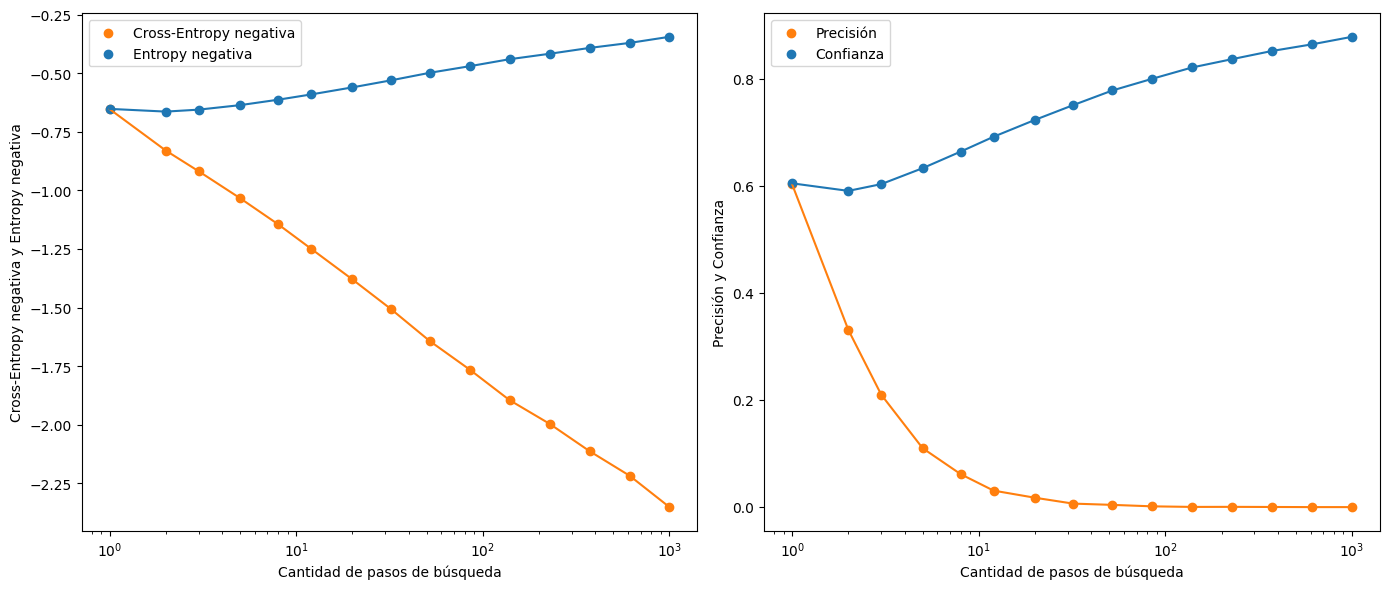

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6171), tensor(0.6243), tensor(0.6498), tensor(0.6432))
(tensor(0.5667), tensor(0.4215), tensor(0.6993), tensor(0.8515))
(tensor(0.5231), tensor(0.3399), tensor(0.7389), tensor(0.9232))
(tensor(0.4638), tensor(0.2658), tensor(0.7857), tensor(0.9630))
(tensor(0.4031), tensor(0.2043), tensor(0.8283), tensor(0.9833))
(tensor(0.3570), tensor(0.1671), tensor(0.8564), tensor(0.9914))
(tensor(0.3047), tensor(0.1299), tensor(0.8859), tensor(0.9957))
(tensor(0.2575), tensor(0.0998), tensor(0.9105), tensor(0.9973))
(tensor(0.2188), tensor(0.0786), tensor(0.9282), tensor(0.9994))
(tensor(0.1875), tensor(0.0627), tensor(0.9420), tensor(0.9996))
(tensor(0.1598), tensor(0.0496), tensor(0.9534), tensor(1.))
(tensor(0.1397), tensor(0.0407), tensor(0.9613), tensor(1.))
(tensor(0.1227), tensor(0.0340), tensor(0.9675), tensor(1.))
(tensor(0.1073), tensor(0.0286), tensor(0.9725), tensor(1.))
(tensor(0.086

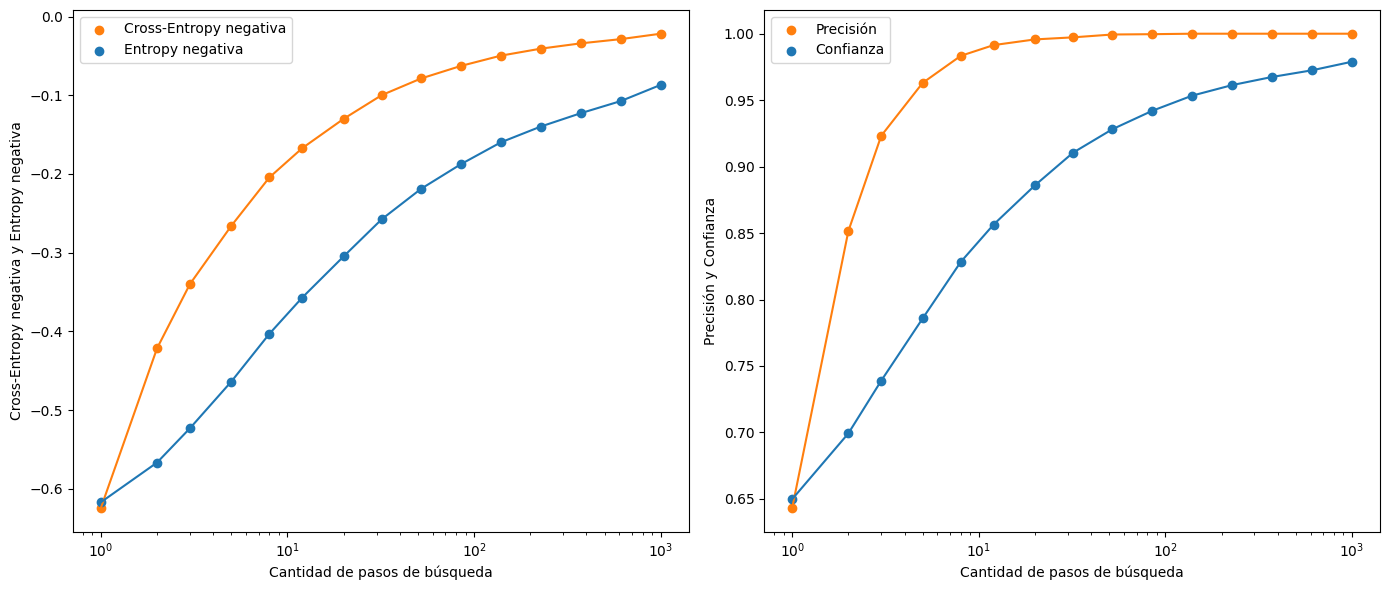

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
(tensor(0.6175), tensor(0.6203), tensor(0.6495), tensor(0.6431))
(tensor(0.6406), tensor(0.8724), tensor(0.6267), tensor(0.3625))
(tensor(0.6258), tensor(1.0150), tensor(0.6446), tensor(0.2346))
(tensor(0.5987), tensor(1.1792), tensor(0.6763), tensor(0.1235))
(tensor(0.5607), tensor(1.3615), tensor(0.7159), tensor(0.0618))
(tensor(0.5345), tensor(1.4784), tensor(0.7414), tensor(0.0401))
(tensor(0.4866), tensor(1.6903), tensor(0.7813), tensor(0.0162))
(tensor(0.4521), tensor(1.8458), tensor(0.8070), tensor(0.0086))
(tensor(0.4134), tensor(2.0242), tensor(0.8342), tensor(0.0042))
(tensor(0.3784), tensor(2.1908), tensor(0.8561), tensor(0.0021))
(tensor(0.3466), tensor(2.3484), tensor(0.8743), tensor(0.0007))
(tensor(0.3214), tensor(2.4793), tensor(0.8884), tensor(0.0004))
(tensor(0.3006), tensor(2.5972), tensor(0.8989), tensor(0.))
(tensor(0.2784), tensor(2.7314), tensor(0.9096), tensor(0.))
(tens

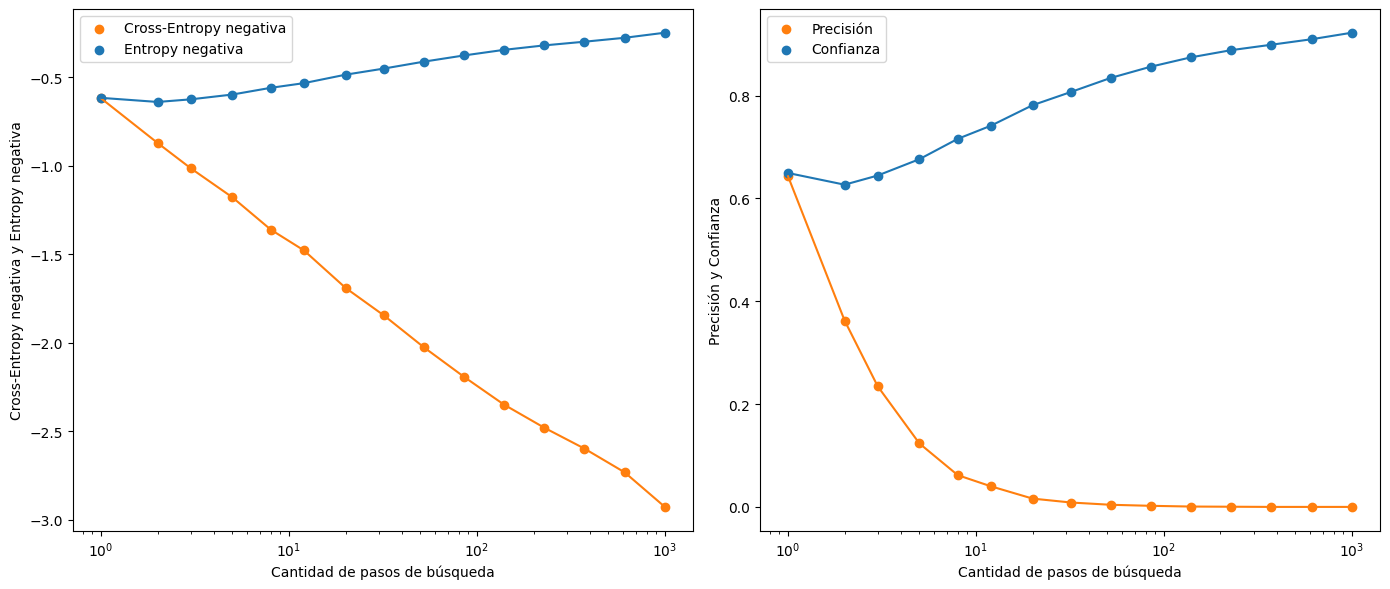

In [31]:
plot_maximizar_ce(1)
plot_maximizar_ce_opuesto(1)
plot_maximizar_ce(2)
plot_maximizar_ce_opuesto(2)
plot_maximizar_ce(4)
plot_maximizar_ce_opuesto(4)
plot_maximizar_ce(8)
plot_maximizar_ce_opuesto(8)

In [32]:
def evalDebate(n, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence,num_turns,num_pixels):
    data=X_test
    game_tensor=torch.ones_like(torch.Tensor(data))*-1
    game = parallelGame(game_tensor,data)
    
    starters=torch.randint(0, 2, (data.shape[0],))
    print(starters)
    
    neg_entropy_score=EvenOddCrossEntropyScore(1-starters)
    pos_entropy_score=EvenOddCrossEntropyScore(starters)

    for i in range(num_pixels):
        player = mcts(game)
        if((i//(num_pixels//num_turns))%2==0):
            pixels=player.search(num_pixels-i,n,model,pos_entropy_score,minimum=True)
        else:
            pixels=player.search(num_pixels-i,n,model,neg_entropy_score,minimum=True)
        
        game.add_pixel(pixels)
        
    return torch.mean(game.evaluate(model,even_odd_entropy)),torch.mean(game.evaluate(model,ce_even_odd)),torch.mean(game.evaluate(model,even_odd_confidence)),torch.mean(game.evaluate(model,acc_even_odd))

In [33]:
ce_even_odd = EvenOddCrossEntropyScore(Y_test)
acc_even_odd = EvenOddAccuracyScore(Y_test)

steps=np.ceil(np.logspace(0,np.log10(1000),15))
print(steps)
entropies_eo_1=[]
crossentropies_eo_1=[]
confidences_eo_1=[]
accuracies_eo_1=[]
    
for i in range(len(steps)):
    k=evalDebate(int(steps[i]),ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence,2,8)
    print("1 Turns:",k)
    entropies_eo_1.append(k[0])
    crossentropies_eo_1.append(k[1])
    confidences_eo_1.append(k[2])
    accuracies_eo_1.append(k[3])

ce_even_odd = EvenOddCrossEntropyScore(Y_test)
acc_even_odd = EvenOddAccuracyScore(Y_test)

steps=np.ceil(np.logspace(0,np.log10(1000),15))
print(steps)
entropies_eo_2=[]
crossentropies_eo_2=[]
confidences_eo_2=[]
accuracies_eo_2=[]
    
for i in range(len(steps)):
    k=evalDebate(int(steps[i]),ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence,4,8)
    print("2 Turns:",k)
    entropies_eo_2.append(k[0])
    crossentropies_eo_2.append(k[1])
    confidences_eo_2.append(k[2])
    accuracies_eo_2.append(k[3])


ce_even_odd = EvenOddCrossEntropyScore(Y_test)
acc_even_odd = EvenOddAccuracyScore(Y_test)

steps=np.ceil(np.logspace(0,np.log10(1000),15))
print(steps)
entropies_eo_4=[]
crossentropies_eo_4=[]
confidences_eo_4=[]
accuracies_eo_4=[]
    
for i in range(len(steps)):
    k=evalDebate(int(steps[i]),ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence,8,8)
    print("4 Turns:",k)
    entropies_eo_4.append(k[0])
    crossentropies_eo_4.append(k[1])
    confidences_eo_4.append(k[2])
    accuracies_eo_4.append(k[3])

/tmp/ipykernel_23/606736386.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/606736386.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/3907398009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_h = torch.tensor(pixels[0],dtype=torch.int)
/tmp/ipykernel_23/3907398009.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

[   1.    2.    3.    5.    8.   12.   20.   32.   52.   85.  139.  228.
  373.  611. 1000.]
tensor([1, 1, 0,  ..., 0, 1, 0])
1 Turns: (tensor(0.6191), tensor(0.6169), tensor(0.6479), tensor(0.6450))
tensor([1, 1, 1,  ..., 0, 1, 0])
1 Turns: (tensor(0.6180), tensor(0.6167), tensor(0.6487), tensor(0.6455))
tensor([0, 1, 0,  ..., 0, 1, 1])
1 Turns: (tensor(0.6067), tensor(0.6156), tensor(0.6608), tensor(0.6504))
tensor([1, 1, 0,  ..., 1, 0, 1])
1 Turns: (tensor(0.5865), tensor(0.6252), tensor(0.6803), tensor(0.6362))
tensor([1, 1, 1,  ..., 1, 0, 1])
1 Turns: (tensor(0.5612), tensor(0.6101), tensor(0.7020), tensor(0.6564))
tensor([0, 0, 0,  ..., 1, 1, 0])
1 Turns: (tensor(0.5386), tensor(0.6271), tensor(0.7208), tensor(0.6438))
tensor([0, 0, 0,  ..., 0, 1, 1])
1 Turns: (tensor(0.5085), tensor(0.6181), tensor(0.7450), tensor(0.6550))
tensor([1, 1, 0,  ..., 1, 1, 0])
1 Turns: (tensor(0.4809), tensor(0.6263), tensor(0.7651), tensor(0.6602))
tensor([1, 0, 1,  ..., 0, 1, 1])
1 Turns: (tensor(0

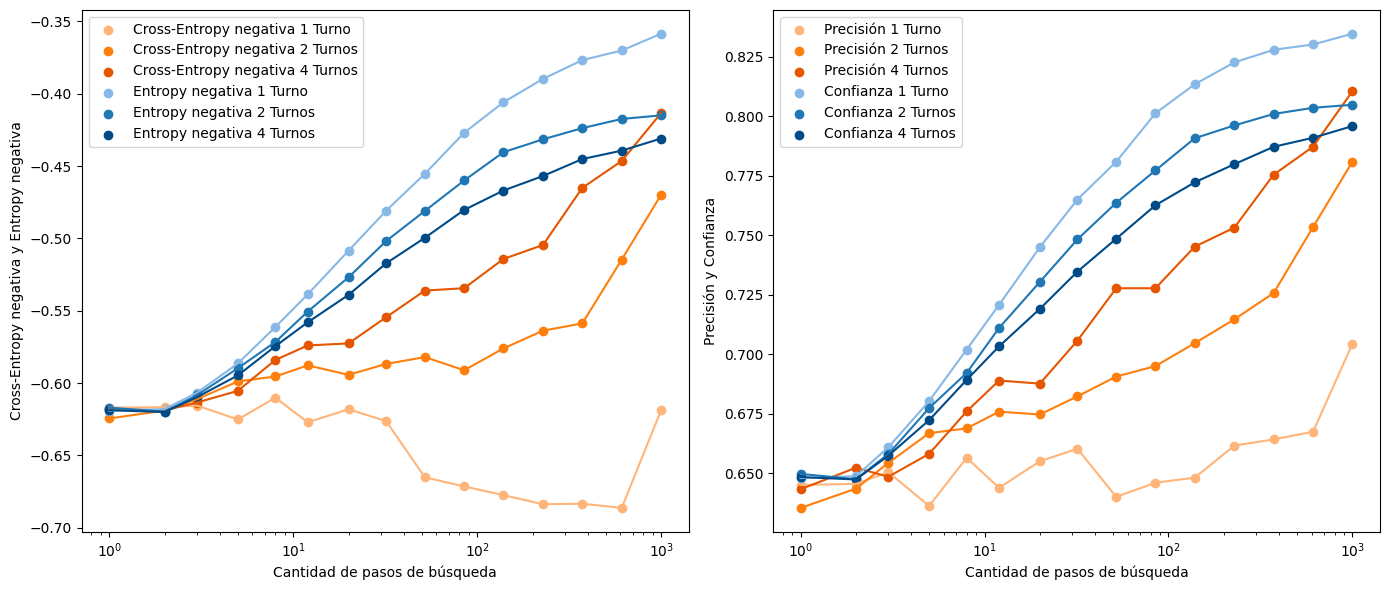

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Colores en tonos de naranja y azul de acuerdo con los turnos
color_naranja_1 = '#ffb57a'  # Naranja claro para 1 turno
color_naranja_2 = '#ff7f0e'  # Naranja intermedio para 2 turnos
color_naranja_4 = '#e65500'  # Naranja oscuro para 4 turnos

color_azul_1 = '#87b8e6'     # Azul claro para 1 turno
color_azul_2 = '#1f77b4'     # Azul intermedio para 2 turnos
color_azul_4 = '#004b87'     # Azul oscuro para 4 turnos

# Gráfico 1 (Cross-Entropy y Entropy)
ax1.scatter(steps, [-ce for ce in crossentropies_eo_1], color=color_naranja_1, label='Cross-Entropy negativa 1 Turno')
ax1.plot(steps, [-ce for ce in crossentropies_eo_1], color=color_naranja_1)
ax1.scatter(steps, [-ce for ce in crossentropies_eo_2], color=color_naranja_2, label='Cross-Entropy negativa 2 Turnos')
ax1.plot(steps, [-ce for ce in crossentropies_eo_2], color=color_naranja_2)
ax1.scatter(steps, [-ce for ce in crossentropies_eo_4], color=color_naranja_4, label='Cross-Entropy negativa 4 Turnos')
ax1.plot(steps, [-ce for ce in crossentropies_eo_4], color=color_naranja_4)

ax1.scatter(steps, [-e for e in entropies_eo_1], color=color_azul_1, label='Entropy negativa 1 Turno')
ax1.plot(steps, [-e for e in entropies_eo_1], color=color_azul_1)
ax1.scatter(steps, [-e for e in entropies_eo_2], color=color_azul_2, label='Entropy negativa 2 Turnos')
ax1.plot(steps, [-e for e in entropies_eo_2], color=color_azul_2)
ax1.scatter(steps, [-e for e in entropies_eo_4], color=color_azul_4, label='Entropy negativa 4 Turnos')
ax1.plot(steps, [-e for e in entropies_eo_4], color=color_azul_4)

ax1.set_xscale('log')
ax1.set_xlabel('Cantidad de pasos de búsqueda')
ax1.set_ylabel('Cross-Entropy negativa y Entropy negativa')
ax1.legend()

# Gráfico 2 (Precisión y Confianza)
ax2.scatter(steps, accuracies_eo_1, color=color_naranja_1, label='Precisión 1 Turno')
ax2.plot(steps, accuracies_eo_1, color=color_naranja_1)
ax2.scatter(steps, accuracies_eo_2, color=color_naranja_2, label='Precisión 2 Turnos')
ax2.plot(steps, accuracies_eo_2, color=color_naranja_2)
ax2.scatter(steps, accuracies_eo_4, color=color_naranja_4, label='Precisión 4 Turnos')
ax2.plot(steps, accuracies_eo_4, color=color_naranja_4)

ax2.scatter(steps, confidences_eo_1, color=color_azul_1, label='Confianza 1 Turno')
ax2.plot(steps, confidences_eo_1, color=color_azul_1)
ax2.scatter(steps, confidences_eo_2, color=color_azul_2, label='Confianza 2 Turnos')
ax2.plot(steps, confidences_eo_2, color=color_azul_2)
ax2.scatter(steps, confidences_eo_4, color=color_azul_4, label='Confianza 4 Turnos')
ax2.plot(steps, confidences_eo_4, color=color_azul_4)

ax2.set_xscale('log')
ax2.set_xlabel('Cantidad de pasos de búsqueda')
ax2.set_ylabel('Precisión y Confianza')
ax2.legend()

plt.tight_layout()
plt.savefig('Debate_pixeles.png', dpi=300)
plt.show()

In [35]:
data=X_test[5:6]
game_tensor=torch.ones_like(torch.Tensor(data))*-1
game = parallelGame(game_tensor,data)

starters=torch.tensor([0])
print(starters)
list_pixels=[]

neg_entropy_score=EvenOddCrossEntropyScore(1-starters)
pos_entropy_score=EvenOddCrossEntropyScore(starters)

probs=torch.softmax(model(data.to(device)),dim=1)
print(torch.round(probs*100))
probs=torch.softmax(model(game.tensor.to(device)),dim=1)
    
print(torch.round(probs*100))
even_probs = probs[:, [0, 2, 4, 6, 8]].sum(dim=1)
print(torch.round(even_probs*100))
    
for i in range(8):
    player = mcts(game)
    if(i%2==0):
        pixels=player.search(8-i,1000,model,pos_entropy_score,minimum=True)
    else:
        pixels=player.search(8-i,1000,model,neg_entropy_score,minimum=True)
    print(pixels)
    list_pixels.append([i+1,pixels[0][0],pixels[1][0]])
    probs=torch.softmax(model(game.tensor.to(device)),dim=1)
    
    print(torch.round(probs*100))
    even_probs = probs[:, [0, 2, 4, 6, 8]].sum(dim=1)
    print(torch.round(even_probs*100))
    game.add_pixel(pixels)


tensor([0])
tensor([[12.,  0., 16., 19.,  2., 26.,  7.,  0., 19.,  0.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([[10., 11., 10., 10.,  9.,  9., 10., 11., 10., 10.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([49.], device='cuda:0', grad_fn=<RoundBackward0>)


/tmp/ipykernel_23/606736386.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)


tensor([[ 2],
        [10]])
tensor([[10., 11., 10., 10.,  9.,  9., 10., 11., 10., 10.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([49.], device='cuda:0', grad_fn=<RoundBackward0>)


/tmp/ipykernel_23/3907398009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_h = torch.tensor(pixels[0],dtype=torch.int)
/tmp/ipykernel_23/3907398009.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_w = torch.tensor(pixels[1],dtype=torch.int)


tensor([[7],
        [3]])
tensor([[16.,  8., 23.,  7.,  1.,  8., 28.,  0.,  9.,  0.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([77.], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[10],
        [ 5]])
tensor([[10., 10., 26.,  8.,  1.,  8., 27.,  0., 10.,  0.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([74.], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[13],
        [ 8]])
tensor([[ 8.,  2., 33.,  1.,  0.,  2., 47.,  0.,  6.,  0.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([95.], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[ 7],
        [15]])
tensor([[38.,  4., 18.,  4.,  0.,  4.,  3.,  0., 28.,  0.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([88.], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[11],
        [ 6]])
tensor([[38.,  4., 18.,  4.,  0.,  4.,  3.,  0., 28.,  0.]], device='cuda:0',
       grad_fn=<RoundBackward0>)
tensor([88.], device='cuda:0', grad_fn=<RoundBackward0>)
tensor([[6],
    

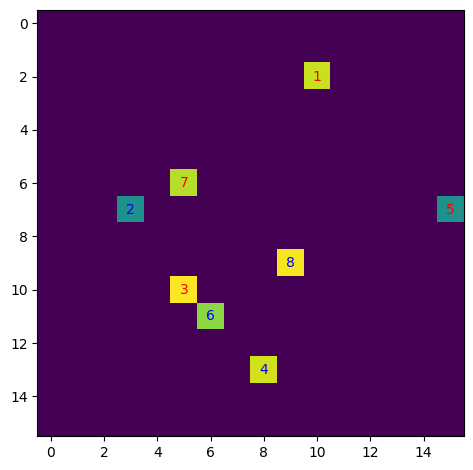

In [36]:
plt.imshow(game.tensor[0][0])
for i in range(8):
    if(i%2==0):
        plt.text(list_pixels[i][2], list_pixels[i][1], '{:0.0f}'.format(list_pixels[i][0]), ha='center', va='center',c='red')
    if(i%2==1):
        plt.text(list_pixels[i][2], list_pixels[i][1], '{:0.0f}'.format(list_pixels[i][0]), ha='center', va='center',c='blue')
plt.tight_layout()
plt.savefig('Debate6StartOdd', dpi=300)
plt.show()

In [37]:
def evalDebateAvsB(nA, nB, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence,num_turns,num_pixels):
    data=X_test
    game_tensor=torch.ones_like(torch.Tensor(data))*-1
    game = parallelGame(game_tensor,data)
    
    #starters=torch.randint(0, 2, (data.shape[0],))*2-1
    starters=Y_test
    print(starters)
    
    neg_entropy_score=EvenOddCrossEntropyScore(9-starters)
    pos_entropy_score=EvenOddCrossEntropyScore(starters)
    
    
    for i in range(num_pixels):
        player = mcts(game)
        if((i//(num_pixels//num_turns))%2==0):
            pixels=player.search(num_pixels-i,nA,model,pos_entropy_score,minimum=True)
        else:
            pixels=player.search(num_pixels-i,nB,model,neg_entropy_score,minimum=True)
        
        game.add_pixel(pixels)
        
    return torch.mean(game.evaluate(model,even_odd_entropy)),torch.mean(game.evaluate(model,ce_even_odd)),torch.mean(game.evaluate(model,even_odd_confidence)),torch.mean(game.evaluate(model,acc_even_odd))

In [38]:
def evalDebateAvsBReverse(nA, nB, ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence,num_turns,num_pixels):
    data=X_test
    game_tensor=torch.ones_like(torch.Tensor(data))*-1
    game = parallelGame(game_tensor,data)
    
    #starters=torch.randint(0, 2, (data.shape[0],))*2-1
    starters=Y_test
    print(starters)
    
    neg_entropy_score=EvenOddCrossEntropyScore(9-starters)
    pos_entropy_score=EvenOddCrossEntropyScore(starters)
    
    neg_accuracy_score=EvenOddAccuracyScore(9-starters)
    pos_accuracy_score=EvenOddAccuracyScore(starters)
    
    
    
    for i in range(num_pixels):
        player = mcts(game)
        if((i//(num_pixels//num_turns))%2==0):
            pixels=player.search(num_pixels-i,nB,model,neg_entropy_score,minimum=True)
        else:
            pixels=player.search(num_pixels-i,nA,model,pos_entropy_score,minimum=True)
        
        game.add_pixel(pixels)
        
    return torch.mean(game.evaluate(model,even_odd_entropy)),torch.mean(game.evaluate(model,ce_even_odd)),torch.mean(game.evaluate(model,even_odd_confidence)),torch.mean(game.evaluate(model,acc_even_odd))

In [39]:
steps = np.ceil(np.logspace(0, np.log10(500), 5))
# Initialize matrix for storing the results
ce_matrix = np.zeros((5, 5))
acc_matrix = np.zeros((5, 5))

# Populate the matrices with evaluations
for i in range(5):
    for j in range(5):
        # Call evalDebateAvsB with (steps[i], steps[j]) and extract ce and acc
        result = evalDebateAvsB(int(steps[i]), int(steps[j]), ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence, 8, 8)
        ce_matrix[i, j] = result[1]
        acc_matrix[i, j] = result[3]
        print(result[1],result[3])

# Output the ce and acc matrices
print("CE Matrix:")
print(ce_matrix)
print("\nAccuracy Matrix:")
print(acc_matrix)

tensor([8, 1, 9,  ..., 3, 0, 9])


/tmp/ipykernel_23/606736386.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/3907398009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_h = torch.tensor(pixels[0],dtype=torch.int)
/tmp/ipykernel_23/3907398009.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_w = torch.tensor(pixels[1],dtype=torch.int)


tensor(0.6152) tensor(0.6458)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.9121) tensor(0.3426)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.2068) tensor(0.1742)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.5280) tensor(0.0762)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.8013) tensor(0.0462)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.4259) tensor(0.8398)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.6489) tensor(0.6142)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.9120) tensor(0.3988)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.1925) tensor(0.2436)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.4454) tensor(0.1683)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.3121) tensor(0.9057)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.4792) tensor(0.7654)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.6857) tensor(0.5954)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.9340) tensor(0.4395)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.1392) tensor(0.3496)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.2203) tensor(0.9463)
tensor([8, 1, 9,  ..., 3,

/tmp/ipykernel_23/4088017098.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/4088017098.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/4088017098.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/4088017098.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])


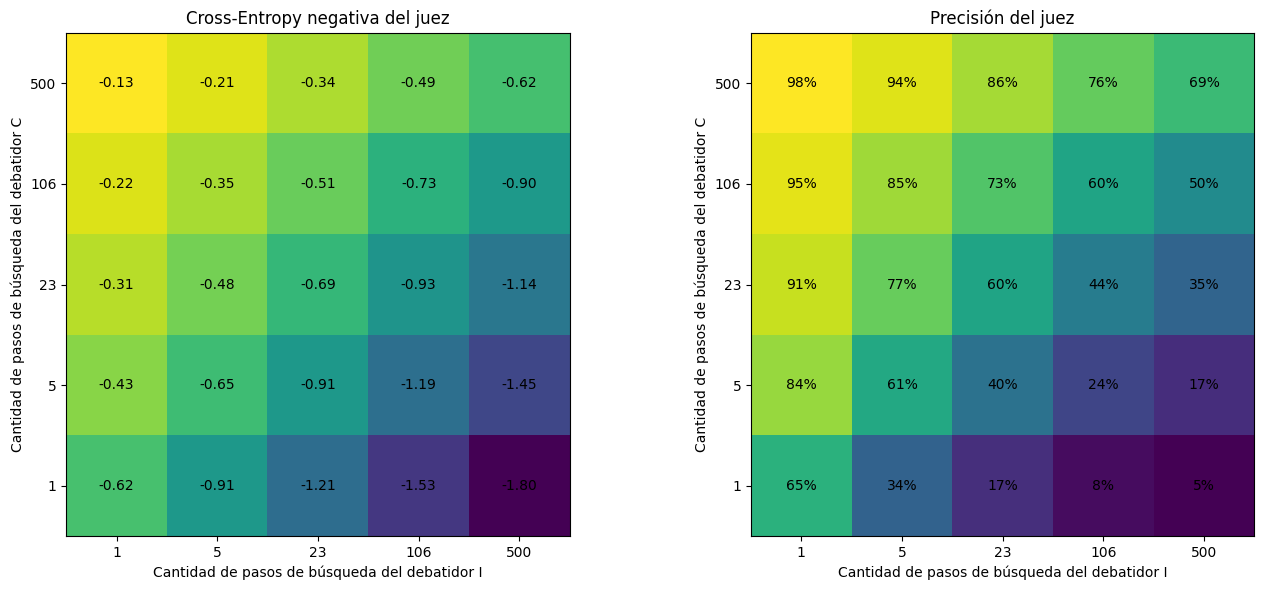

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.matshow(-ce_matrix,origin='lower')

for (i, j), z in np.ndenumerate(-ce_matrix):
    ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title("Cross-Entropy negativa del juez")
ax1.set_xlabel('Cantidad de pasos de búsqueda del debatidor I')
ax1.set_ylabel('Cantidad de pasos de búsqueda del debatidor C')
ax1.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
ax1.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])

ax2.matshow(acc_matrix,origin='lower')
for (i, j), z in np.ndenumerate(acc_matrix):
    ax2.text(j, i, '{:0.0f}'.format(100*z)+'%', ha='center', va='center')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title("Precisión del juez")
ax2.set_xlabel('Cantidad de pasos de búsqueda del debatidor I')
ax2.set_ylabel('Cantidad de pasos de búsqueda del debatidor C')
ax2.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
ax2.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])

fig.tight_layout()
fig.savefig('acc_matrix_pos.png', dpi=300)
fig.show()

In [41]:
steps = np.ceil(np.logspace(0, np.log10(500), 5))
# Initialize matrix for storing the results
ce_matrix_neg = np.zeros((5, 5))
acc_matrix_neg = np.zeros((5, 5))

# Populate the matrices with evaluations
for i in range(5):
    for j in range(5):
        # Call evalDebateAvsB with (steps[i], steps[j]) and extract ce and acc
        result = evalDebateAvsBReverse(int(steps[i]), int(steps[j]), ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence, 8, 8)
        ce_matrix_neg[i, j] = result[1]
        acc_matrix_neg[i, j] = result[3]
        print(result[1],result[3])

# Output the ce and acc matrices
print("CE Matrix:")
print(ce_matrix_neg)
print("\nAccuracy Matrix:")
print(acc_matrix_neg)

tensor([8, 1, 9,  ..., 3, 0, 9])


/tmp/ipykernel_23/606736386.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/606736386.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/3907398009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_h = torch.tensor(pixels[0],dtype=torch.int)
/tmp/ipykernel_23/3907398009.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

tensor(0.6212) tensor(0.6456)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.8436) tensor(0.4054)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.0574) tensor(0.2769)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.2588) tensor(0.1901)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.5127) tensor(0.1139)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.3854) tensor(0.8789)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.5484) tensor(0.7261)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.7010) tensor(0.5793)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.8618) tensor(0.4617)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.0741) tensor(0.3471)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.2326) tensor(0.9662)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.3253) tensor(0.9010)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.4320) tensor(0.8095)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.5429) tensor(0.7193)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.6977) tensor(0.6062)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.1345) tensor(0.9923)
tensor([8, 1, 9,  ..., 3,

/tmp/ipykernel_23/4067105971.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/4067105971.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/4067105971.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/4067105971.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])


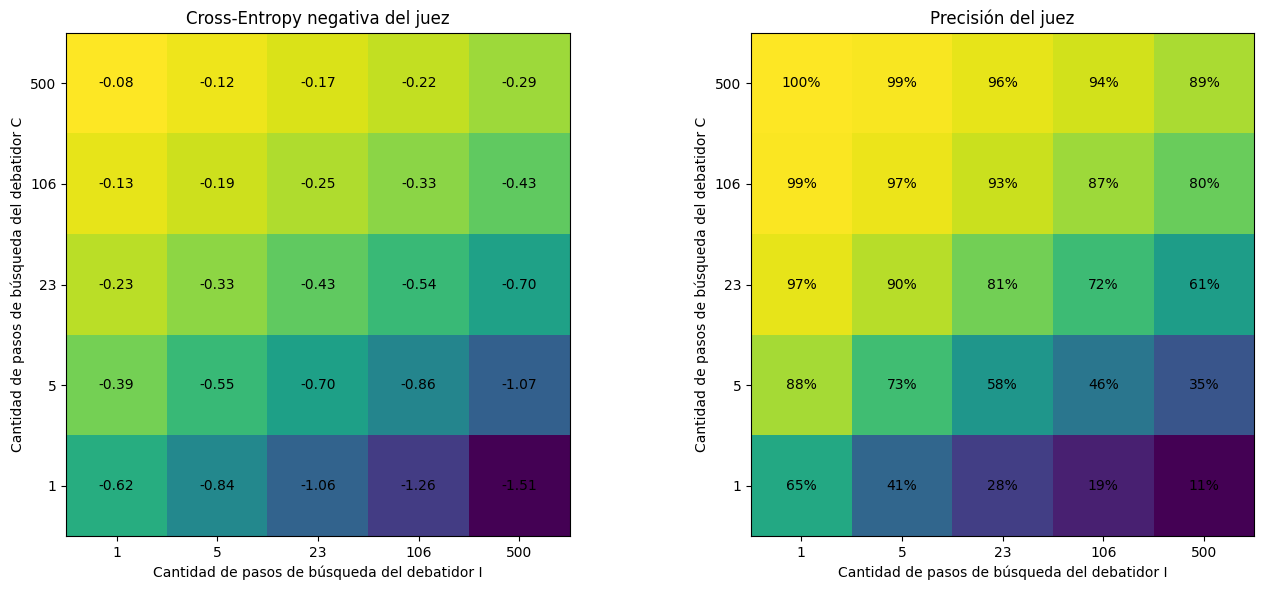

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.matshow(-ce_matrix_neg,origin='lower')

for (i, j), z in np.ndenumerate(-ce_matrix_neg):
    ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title("Cross-Entropy negativa del juez")
ax1.set_xlabel('Cantidad de pasos de búsqueda del debatidor I')
ax1.set_ylabel('Cantidad de pasos de búsqueda del debatidor C')
ax1.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
ax1.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])

ax2.matshow(acc_matrix_neg,origin='lower')
for (i, j), z in np.ndenumerate(acc_matrix_neg):
    ax2.text(j, i, '{:0.0f}'.format(100*z)+'%', ha='center', va='center')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title("Precisión del juez")
ax2.set_xlabel('Cantidad de pasos de búsqueda del debatidor I')
ax2.set_ylabel('Cantidad de pasos de búsqueda del debatidor C')
ax2.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
ax2.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])

fig.tight_layout()
fig.savefig('acc_matrix_neg.png', dpi=300)
fig.show()

/tmp/ipykernel_23/2676766860.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/2676766860.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/2676766860.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/2676766860.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])


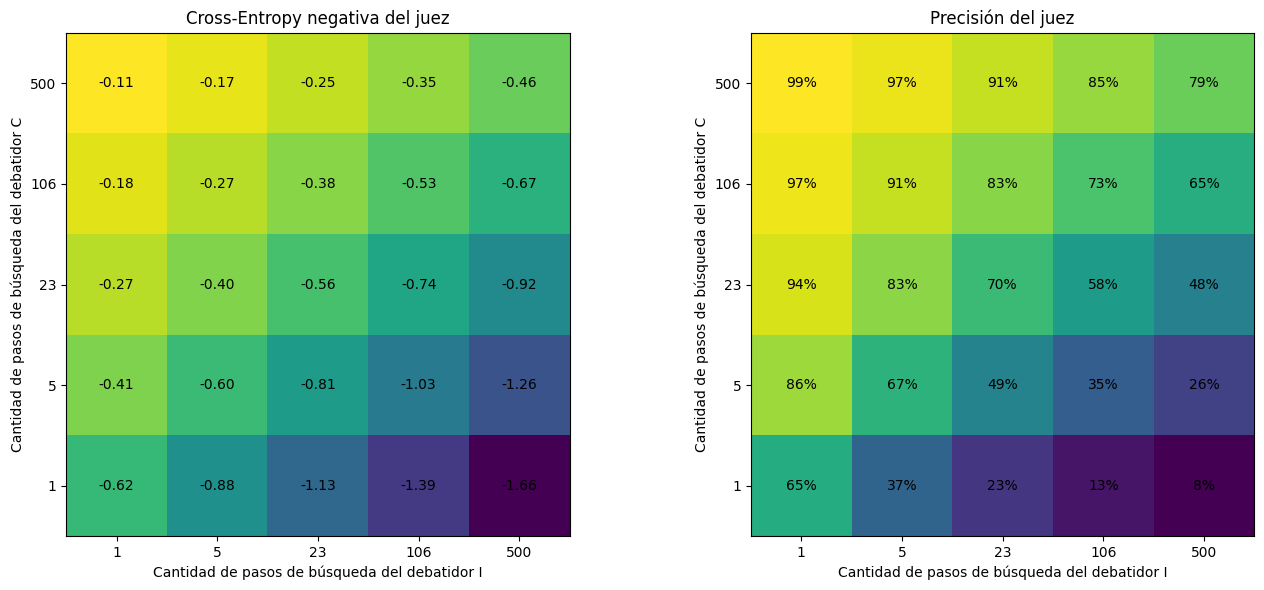

In [43]:
acc_matrix_avg=(acc_matrix+acc_matrix_neg)/2
ce_matrix_avg=(ce_matrix+ce_matrix_neg)/2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.matshow(-ce_matrix_avg,origin='lower')

for (i, j), z in np.ndenumerate(-ce_matrix_avg):
    ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title("Cross-Entropy negativa del juez")
ax1.set_xlabel('Cantidad de pasos de búsqueda del debatidor I')
ax1.set_ylabel('Cantidad de pasos de búsqueda del debatidor C')
ax1.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
ax1.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])

ax2.matshow(acc_matrix_avg,origin='lower')
for (i, j), z in np.ndenumerate(acc_matrix_avg):
    ax2.text(j, i, '{:0.0f}'.format(100*z)+'%', ha='center', va='center')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title("Precisión del juez")
ax2.set_xlabel('Cantidad de pasos de búsqueda del debatidor I')
ax2.set_ylabel('Cantidad de pasos de búsqueda del debatidor C')
ax2.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
ax2.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])

fig.tight_layout()
fig.savefig('acc_matrix_avg.png', dpi=300)
fig.show()

In [44]:
print(torch.sum(Y_test%2==0))
print(torch.sum(Y_test%2!=0))

tensor(4121)
tensor(4279)


In [45]:
steps = np.ceil(np.logspace(0, np.log10(500), 5))
# Initialize matrix for storing the results
ce_matrix_neg_7 = np.zeros((5, 5))
acc_matrix_neg_7 = np.zeros((5, 5))

# Populate the matrices with evaluations
for i in range(5):
    for j in range(5):
        # Call evalDebateAvsB with (steps[i], steps[j]) and extract ce and acc
        result = evalDebateAvsBReverse(int(steps[i]), int(steps[j]), ce_even_odd, even_odd_entropy, acc_even_odd, even_odd_confidence, 7, 7)
        ce_matrix_neg_7[i, j] = result[1]
        acc_matrix_neg_7[i, j] = result[3]
        print(result[1],result[3])

# Output the ce and acc matrices
print("CE Matrix:")
print(ce_matrix_neg_7)
print("\nAccuracy Matrix:")
print(acc_matrix_neg_7)

tensor([8, 1, 9,  ..., 3, 0, 9])


/tmp/ipykernel_23/606736386.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/606736386.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y_test = torch.tensor(Y_test)
/tmp/ipykernel_23/3907398009.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rand_h = torch.tensor(pixels[0],dtype=torch.int)
/tmp/ipykernel_23/3907398009.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gr

tensor(0.6276) tensor(0.6390)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.9208) tensor(0.3126)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.2124) tensor(0.1525)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.5361) tensor(0.0656)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.8110) tensor(0.0386)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.4619) tensor(0.8106)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.6943) tensor(0.5637)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.9574) tensor(0.3529)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.2505) tensor(0.2092)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.4931) tensor(0.1412)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.3438) tensor(0.8930)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.5295) tensor(0.7165)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.7478) tensor(0.5465)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.0055) tensor(0.3865)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(1.2214) tensor(0.2948)
tensor([8, 1, 9,  ..., 3, 0, 9])
tensor(0.2527) tensor(0.9324)
tensor([8, 1, 9,  ..., 3,

/tmp/ipykernel_23/2024696016.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/2024696016.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/2024696016.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
/tmp/ipykernel_23/2024696016.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])


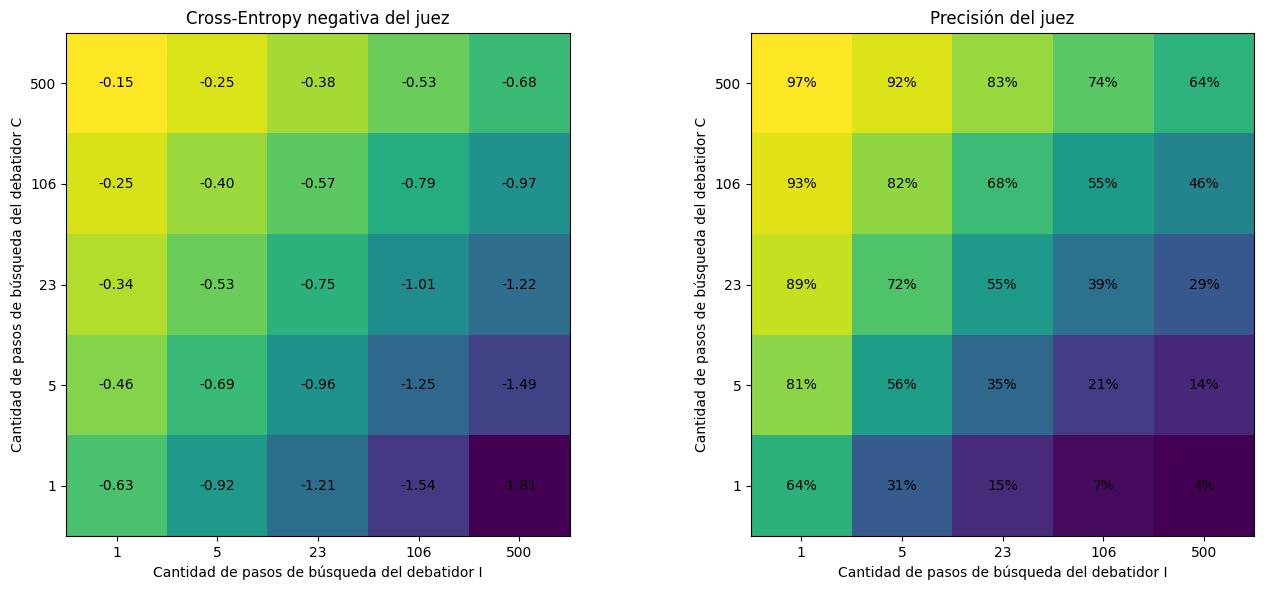

In [46]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.matshow(-ce_matrix_neg_7,origin='lower')

for (i, j), z in np.ndenumerate(-ce_matrix_neg_7):
    ax1.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_title("Cross-Entropy negativa del juez")
ax1.set_xlabel('Cantidad de pasos de búsqueda del debatidor I')
ax1.set_ylabel('Cantidad de pasos de búsqueda del debatidor C')
ax1.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
ax1.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])

ax2.matshow(acc_matrix_neg_7,origin='lower')
for (i, j), z in np.ndenumerate(acc_matrix_neg_7):
    ax2.text(j, i, '{:0.0f}'.format(100*z)+'%', ha='center', va='center')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title("Precisión del juez")
ax2.set_xlabel('Cantidad de pasos de búsqueda del debatidor I')
ax2.set_ylabel('Cantidad de pasos de búsqueda del debatidor C')
ax2.set_xticklabels(['']+[str(int(step)) for step in steps.tolist()])
ax2.set_yticklabels(['']+[str(int(step)) for step in steps.tolist()])

fig.tight_layout()
fig.savefig('acc_matrix_neg_7.png', dpi=300)
fig.show()